# Real coded genetic algorithm

Author: Uros Nikolovski

---

## Contents

# #TODO

## Genetic algorithm description

Genetic algorithm (GA) is optimization algorithm that belongs to the family of the evolutionary algorithms and is inspired by natural selection. In general, GAs can be used to search discrete or continuous spaces, values can be encoded or used as they are, even if they are binary. Single value in the search space is usually called <b>individual</b>. Set of individuals can have multiple names, based on their use.<br>

<b>Population</b> is set of individuals that are 'alive' at the moment. What means for individual to be alive? Alive individuals are individuals that we are currently using to create a solution to our problem.<br>
<b>Mating pool</b> is set of individuals chosen from the population to create offspring. You can have clones (same individuals) in the matting pool, in fact that is really common.<br>
<b>Offspring</b> is set of individuals that is created from the mating pool using some special methods, called crossover. Individuals in the offspring can be also called offspring or children, while individuals in mating pool can be also called parents.<br>

Genetic algorithm start with generating random individuals, creating our first population. After that starts the cycle:
- Selection - choosing which individuals are going to enter mating pool.
- Crossover - creating offspring
- Mutation - mutating offspring individuals
- Replacement(recombination) - combining offspring and population into a new population
- If we are happy with our result, we are done; if not, repeat cycle

A big question arises, how we know if we are happy with our result, we only have some dots in the search space. We need function that will map our individuals from the search space to the set of real numbers. That function is called <b>fitness function</b>.

## GA in this project

In this project we are going to work with real coded GA. That means that our individual will be real numbers. Also it is possible that individuals have multiple dimensions, in that case, they will be represented with the array of numbers, with each number representing one dimension of individual.

## Imports

In [1]:
import numpy as np
import random
from enum import Enum

#Checking things
from typing import Callable
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings('ignore')

#Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import time

## Helping function

This function is used in every strategy to check if parameter is valid, and if not, it will raise an error or warning

In [2]:
def check_parameter(obj, param_name, method_name, strategy_name, default_value, valid_types, kwargs):
    '''
    Function creates propery named params in object obj. params is dictionary that will contain value from kwargs with string key param_name.
    If value that is in kwargs does not meet the valid_types, value will be set to default_value.
    kwargs is also a dictionary
    '''
    try:
        obj.params
    except AttributeError: #obj.params does not exist, so we are going to create it
        obj.params = {}
    try:
        obj.params[param_name] = kwargs[param_name]
    except KeyError:
        obj.params[param_name] = None
    if(obj.params[param_name] == None):
        warnings.warn(f'Use {param_name}={valid_types} kayword argument when using {method_name} {strategy_name}')
    if(not isinstance(obj.params[param_name], valid_types)):
        obj.params[param_name] = None
        warnings.warn(f'{param_name} must be {valid_types} type')
    if(obj.params[param_name] is None):
        obj.params[param_name] = default_value
        warnings.warn(f'Setting default value for {param_name}={default_value}')

## Fitness

In [3]:
class Fitness():
    pass

Fitness is measure of how good the individuals in population are. Fitness function maps individuals to the real numbers so we can compare them. The greater the value the better the individual is.

### Diversity control

Fitness can also support diversity controls. Diversity control is algorithm that tracks how diverse the population of individuals is. If two individuals are really similar, their fitness value will be lowered. Even if the individuals are good, to much of the similar individuals, especially in the beginning of algorithm, can lead to premature convergence to the local optimum.

#### Neighborhood diversity control

The number of individuals within the threshold distance of the observed individual is used by neighbor diversity control to determine the penalty. The fitness value is then divided by the penalty values to determine new fitness values.

In [4]:
class Fitness(Fitness):
    def _neighbor_diversity_control(self, population: np.array) -> np.array:
        threshold = self.params['threshold']
        penalty = np.zeros(shape=(population.shape[0], 1))
        for i in range(len(population)):
            individual = population[i]
            for j in range(len(population)):
                other = population[j]
                distance = sum([abs(individual[k] - other[k]) for k in range(len(individual))])
                if distance < threshold:
                    penalty[i] += 1
        return penalty

### Fitness class

In [5]:
class Fitness(Fitness):
    VALID_DIVERSITY_CONTROL_STRATS = ['neighbor',
                                     'None']
    DEFAULT_THRESHOLD = 0.1
    
    def get_possible_strats(self):
        return str(self.VALID_DIVERSITY_CONTROL_STRATS)
        
    def _check_strat(self, diversity_control_strat: str):
        if not diversity_control_strat in self.VALID_DIVERSITY_CONTROL_STRATS:
            raise ValueError('Diversity strategy name is not recognised, you can use diversity_control_strat=' + self.get_possible_strats())

    def _set_diversity_control(self, diversity_control_strat: str, **kwargs):
        if(diversity_control_strat == 'neighbor'):
            self._diversity_control = self._neighbor_diversity_control
            check_parameter(self, 'threshold', 'neighbor', 'diversity control', self.DEFAULT_THRESHOLD, (int, float), kwargs)
            self.params['treshold'] = float(self.params['treshold'])

        elif(diversity_control_strat == 'None'):
            self._diversity_control = None
        
        else:
            raise AssertionError('Fitness diversity control name exist in the valid diversity control strategies but was not found')
    
    def __init__(self, fitness_function: Callable, system_size, *, diversity_control_strat: str = 'None', threshold: float | None = None):
        if(not isinstance(fitness_function, Callable)):
            raise TypeError('fitness_function must be Callable')
        try:
            individual = np.zeros(system_size)
            fitness_function(individual)
        except IndexError:
            raise IndexError('For your fitness function, this system size is too small')
        self.system_size = system_size
        self._diversity_control_strat = diversity_control_strat
        self._check_strat(diversity_control_strat)
        self._set_diversity_control(diversity_control_strat, threshold=threshold)
        self.function = fitness_function

    def get_info(self):
        return f'Fitness have diversity control - {self._diversity_control_strat} with next parameters:'+ ('\n\t'.join("{0} = {1}".format(key, value)  for key,value in self.params.items()) if self.params.items() else f'\n\tMethod have no parameters') 

### Available methods

In [6]:
class Fitness(Fitness):
    def calculate_fitness(self, population: np.array) -> np.array:
        fitness_values = np.apply_along_axis(self.function, 1, population)
        penalty = self._diversity_control(population) if self._diversity_control != None else None
        return fitness_values/penalty if penalty != None else fitness_values

    def calculate_simple_fitness(self, population: np.array) -> np.array:
        return np.apply_along_axis(self.function, 1, population)

    def funciton(self, individual: np.array) -> float:
        return self.function(individual)

    def rank(self, population: np.array) -> np.array:
        population_fitness = self.calculate_fitness(population)
        return population[np.argsort(population_fitness)[::-1]]

## <a id="selection">Selection</a>

Selection is process of selecting individuals from population and it occurs two times during the GA cycle, once when we want to select individuals and put them in the mating pool. Second time when we created offspring and want to combine population with offspring to create a new population. Because there are two types of selection, in this project we will divide them in two: 
- [Selection strategy](#selection_strategy), describes which individuals we will put in the mating pool
- [Replacement strategy](#replacement_strategy), describes how are we going combine offspring and population into a new population

## <a id='selection_strategy'>Selection strategy</a>

Selection strategy is describing how we choose individuals for mating pool.

### Selection strategies:
- [Roulette wheel selection](#roulette_wheel_selection)
- [Scaled roulette wheel selection](#scaled_roulette_wheel_selection)
- [Ranking selection](#ranking_selection)
- [Tournament selection](#tournament_selection)
- [Random selection](#random_selection)

In [7]:
class Selection():
    #This is not constructor intended to be used if you are not debugging or expanding library
    def __init__(self, mode: str):
        valid = ['debug', 'demo']
        if not mode in valid:
            raise ValueError('Unknown mode')

---
### <a id="roulette_wheel_selection">Roulette wheel (fitness proportional) selection</a>
Probability of selecting certain individual using roulette wheel selection is directly proportional to it's fitness value and inversely proportional to the total fitness of the population. Roulette wheel selection requires only positive fitness values.<br>
$P(x) = \text{fitness}(x)/\sum_{\text{s in population}}^{}\text{fitness}(s)$<br>

In [8]:
class Selection(Selection):
    def _roulette_wheel_selection(self, population: np.array, fitness: Fitness, number_of_individuals_to_select: int):
        population_fitness = fitness.calculate_fitness(population)
        total_fitness = sum(population_fitness)
            
        weights = ()
        for fitness_value in population_fitness:
            if(fitness_value < 0):
                raise ValueError('Error fitness value can\'t be negative')
            weights += (fitness_value/total_fitness, )
        
        return np.array(random.choices(population, weights, k=number_of_individuals_to_select))

#### Demo

The downside of roulette wheel approach is when we are optimizing $f(x)=ax^{2} + b$ the optimum does not depend on $b$ but when value of $b$ is proportionally larger than $ax^{2}$ then the selection pressure will be small.

In the next example we will look at the 2 same population, but we will select individuals based on the different fitness functions. First fitness function have no bias, and it evaluates individuals based on their sum of coordinates, second fitness adds 10 to that number.<br>
$\text{fitness1}(x) = x[0] + x[1]$<br>
$\text{fitness2}(x) = x[0] + x[1] + 10$<br>

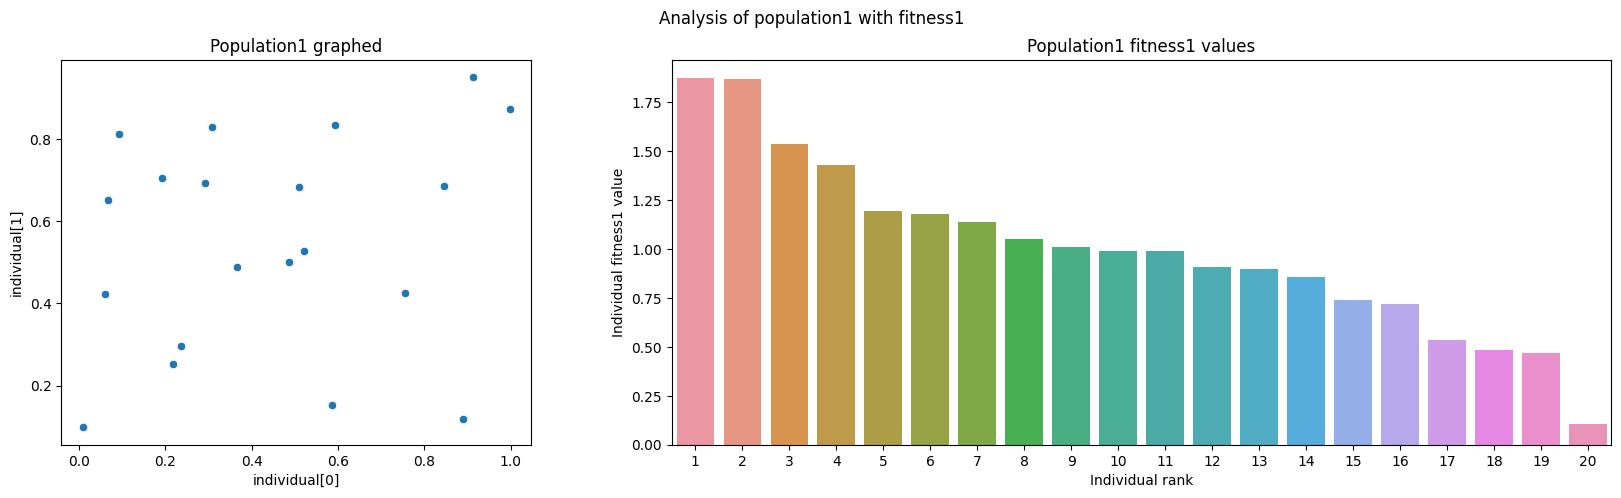

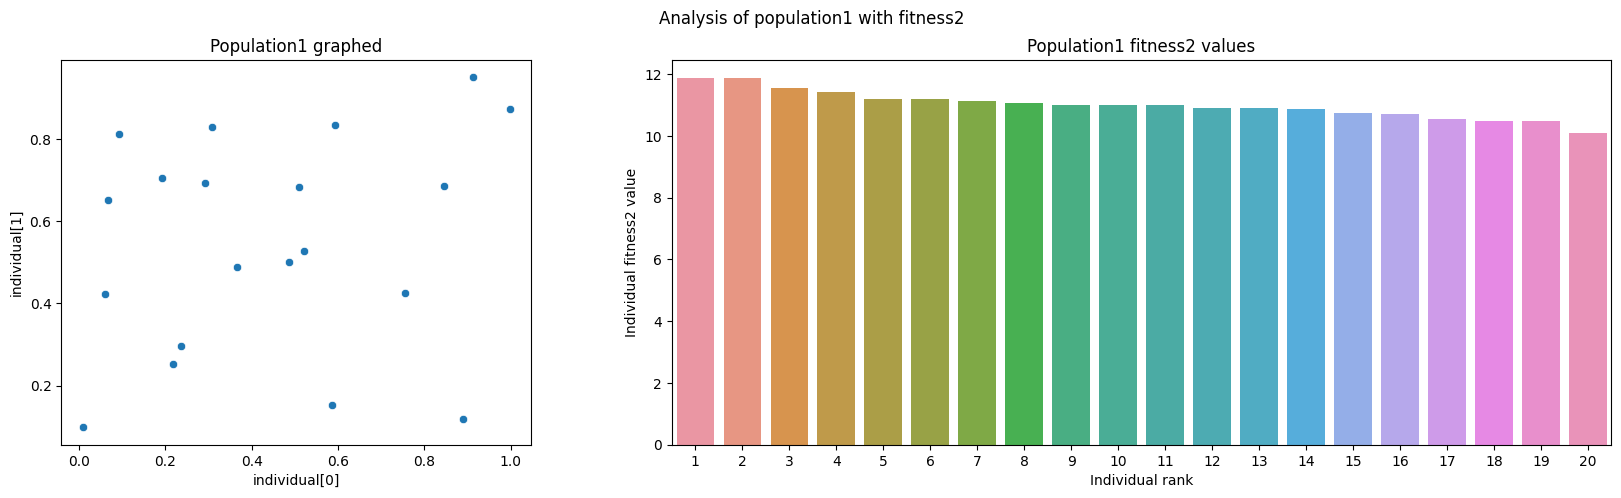

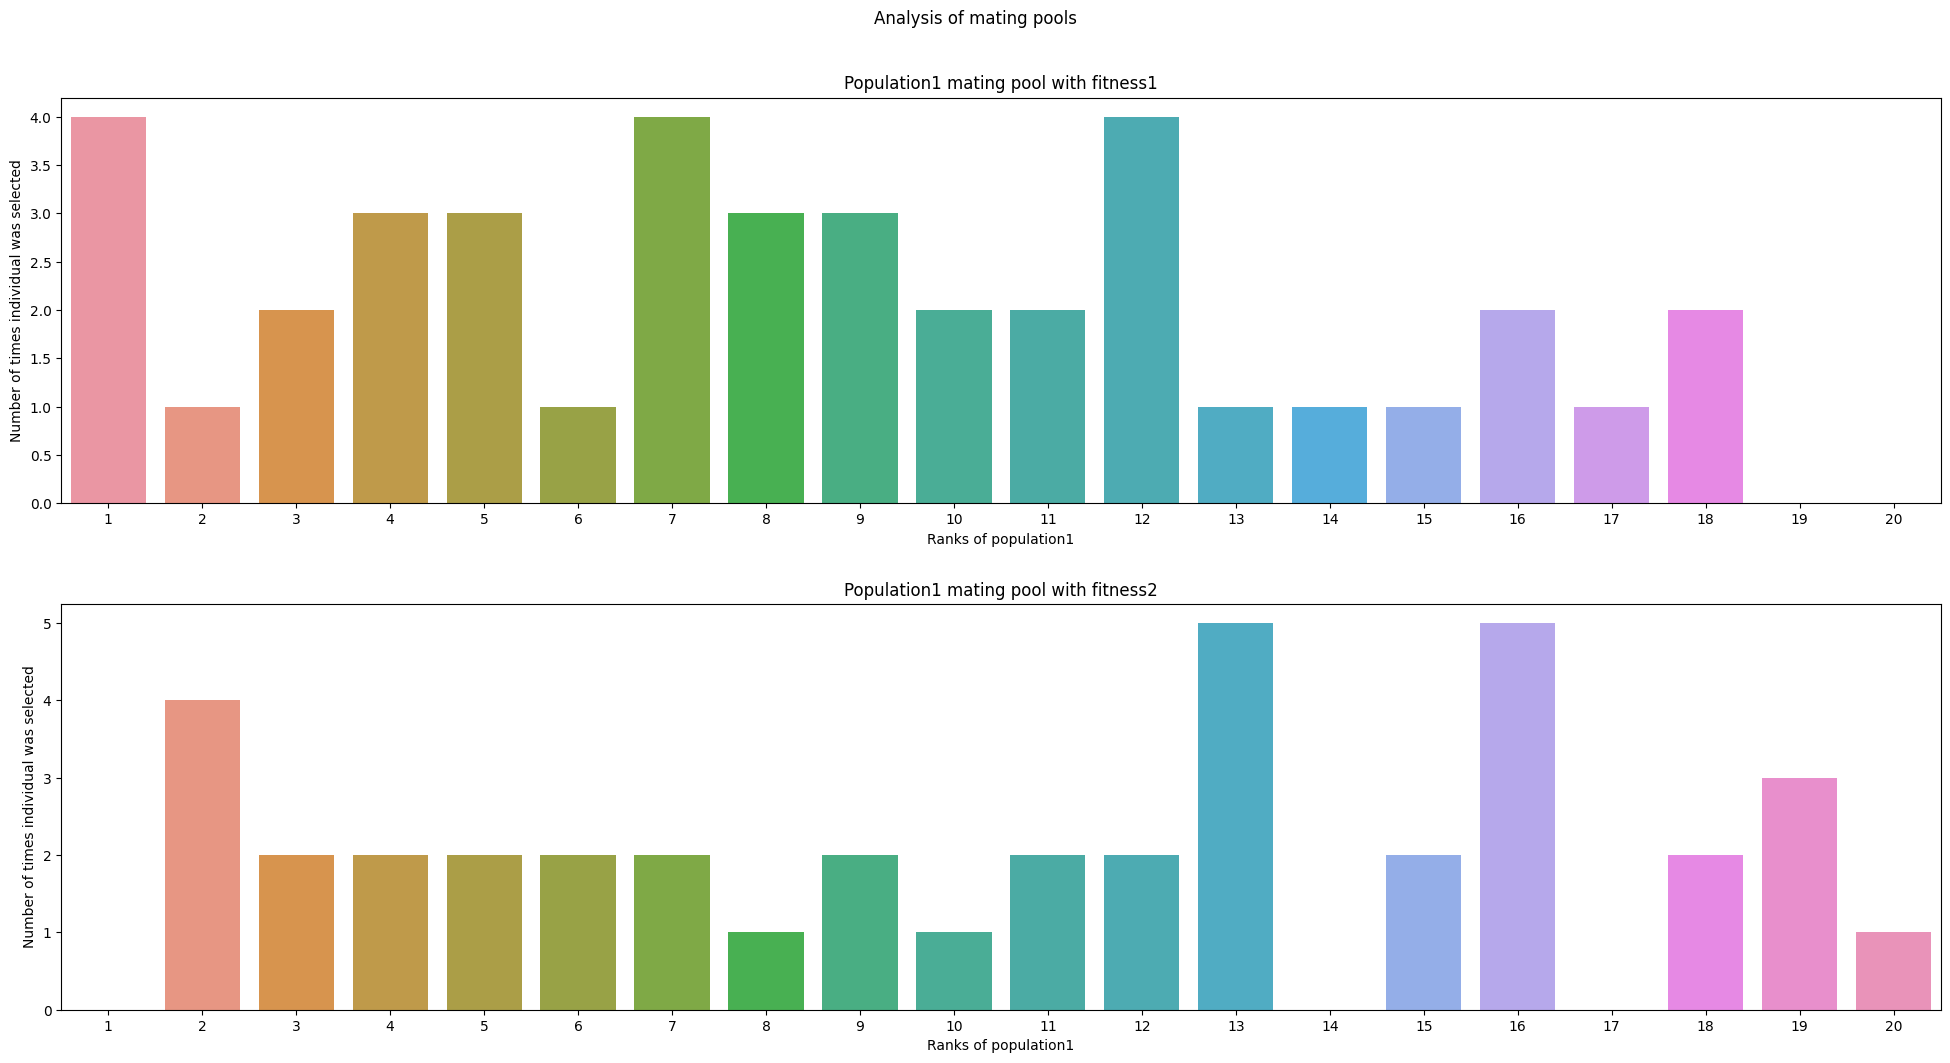

In [9]:
selection = Selection('demo')

number_of_individuals = 20
number_of_individuals_to_select = 40

fitness_function1 = lambda x: x[0] + x[1] #Simple fitness function, the bigger the sum of coordinates is, the better the individual is
fitness_function2 = lambda x: x[0] + x[1] + 10 #Same as previous one, but with bias 10

fitness1 = Fitness(fitness_function1, 2)
fitness2 = Fitness(fitness_function2, 2)

population1 = np.empty(shape=(number_of_individuals, 2))

#Assigning random values [0, 1) to individuals
for individual in population1:
    individual[0] = random.random()
    individual[1] = random.random()

population1_fitness1 = fitness1.rank(population1)
population1_fitness2 = fitness2.rank(population1)

mating_pool1 = selection._roulette_wheel_selection(population1_fitness1, fitness1, number_of_individuals_to_select)
mating_pool2 = selection._roulette_wheel_selection(population1_fitness2, fitness2, number_of_individuals_to_select)

#Plotting population 1 info using fitness 2
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.scatterplot(x=[individual[0] for individual in population1_fitness1], y=[individual[1] for individual in population1_fitness1], ax=axs1[0])
sns.barplot(x=[str(i) for i in range(1, len(population1_fitness1) + 1)], y=fitness1.calculate_fitness(population1_fitness1), ax=axs1[1])
fig1.suptitle('Analysis of population1 with fitness1')
axs1[0].set_title('Population1 graphed')
axs1[1].set_title('Population1 fitness1 values')
axs1[0].set_xlabel('individual[0]')
axs1[0].set_ylabel('individual[1]')
axs1[1].set_xlabel('Individual rank')
axs1[1].set_ylabel('Individual fitness1 value')

#Plotting population 1 info using fitness 2
fig2, axs2 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.scatterplot(x=[individual[0] for individual in population1_fitness2], y=[individual[1] for individual in population1_fitness2], ax=axs2[0])
sns.barplot(x=[str(i) for i in range(1, len(population1_fitness2) + 1)], y=fitness2.calculate_fitness(population1_fitness2), ax=axs2[1])
fig2.suptitle('Analysis of population1 with fitness2')
axs2[0].set_title('Population1 graphed')
axs2[1].set_title('Population1 fitness2 values')
axs2[0].set_xlabel('individual[0]')
axs2[0].set_ylabel('individual[1]')
axs2[1].set_xlabel('Individual rank')
axs2[1].set_ylabel('Individual fitness2 value')

#Counting every individual appearance in mating pool
appearance1 = np.empty(number_of_individuals)
appearance2 = np.empty(number_of_individuals)

for i in range(number_of_individuals):
    individual1 = population1_fitness1[i]
    individual2 = population1_fitness2[i]

    appearance1[i] = sum([x[0] == individual1[0] and x[1] == individual1[1] for x in mating_pool1])
    appearance2[i] = sum([x[0] == individual2[0] and x[1] == individual2[1] for x in mating_pool2])

#Plotting mating pool info
fig3, axs3 = plt.subplots(nrows=2, height_ratios=[1,1], figsize=(20, 11))
sns.barplot(x=[str(i) for i in range(1, len(population1_fitness1) + 1)], y=appearance1, ax=axs3[0])
sns.barplot(x=[str(i) for i in range(1, len(population1_fitness2) + 1)], y=appearance2, ax=axs3[1])
fig3.suptitle('Analysis of mating pools')
axs3[0].set_title('Population1 mating pool with fitness1')
axs3[1].set_title('Population1 mating pool with fitness2')
axs3[0].set_xlabel('Ranks of population1')
axs3[0].set_ylabel('Number of times individual was selected')
axs3[1].set_xlabel('Ranks of population1')
axs3[1].set_ylabel('Number of times individual was selected')
fig3.tight_layout(pad=2.5)

As we can see on the graphs of the selected individuals the selection pressure of the individuals in the fitness 2 mating pool is smaller because of the strong bias. Selected individuals in mating pool 2 look more like a random selected individuals, while in the first population we see that the first half of the better individuals are selected more often than the worst half.<br>

---
### <a id="scaled_roulette_wheel_selection">Scaled roulette wheel (scaled fitness proportional) selection</a>
Scaled roulette wheel selection is similar to the basic roulette wheel selection in case that probability of selecting the individual is directly proportional to it's fitness, but it is inversely proportional to the fitness value of the worst individual. And same as with the roulette wheel selection, scaled version only works with positive fitness values.<br>
$P(x) = \text{fitness}(x)/\min_{\forall s \in \text{Population}} (\text{fitness}(s))$<br>

In [10]:
class Selection(Selection):
    def _scaled_roulette_wheel_selection(self, population: np.array, fitness: Callable, number_of_individuals_to_select: int):
        population_fitness = fitness.calculate_fitness(population)
        min_fitness = min(population_fitness)
        if min_fitness < 0:
            raise ValueError('Error fitness value can\'t be negative')
            
        weights = ()
        for fitness_value in population_fitness:
            weights += (fitness_value/min_fitness, )
        
        return np.array(random.choices(population, weights, k=number_of_individuals_to_select))

#### Demo

Scaled roulette wheel selection solves the problem that we outlined about roulette wheel selection.<br>
However, problem with this selection is that selection pressure is too large and if we have one individual that is outperforming everyone else, that individual can overcrowd mating pool.

In the next example we will look at two different populations. In the first one we have totally random individuals. In the second one we have 3 really good individuals and other ones are just random. In both cases we are using the same fitness function.<br>
$\text{fitness}(x) = x[0] + x[1]$<br>

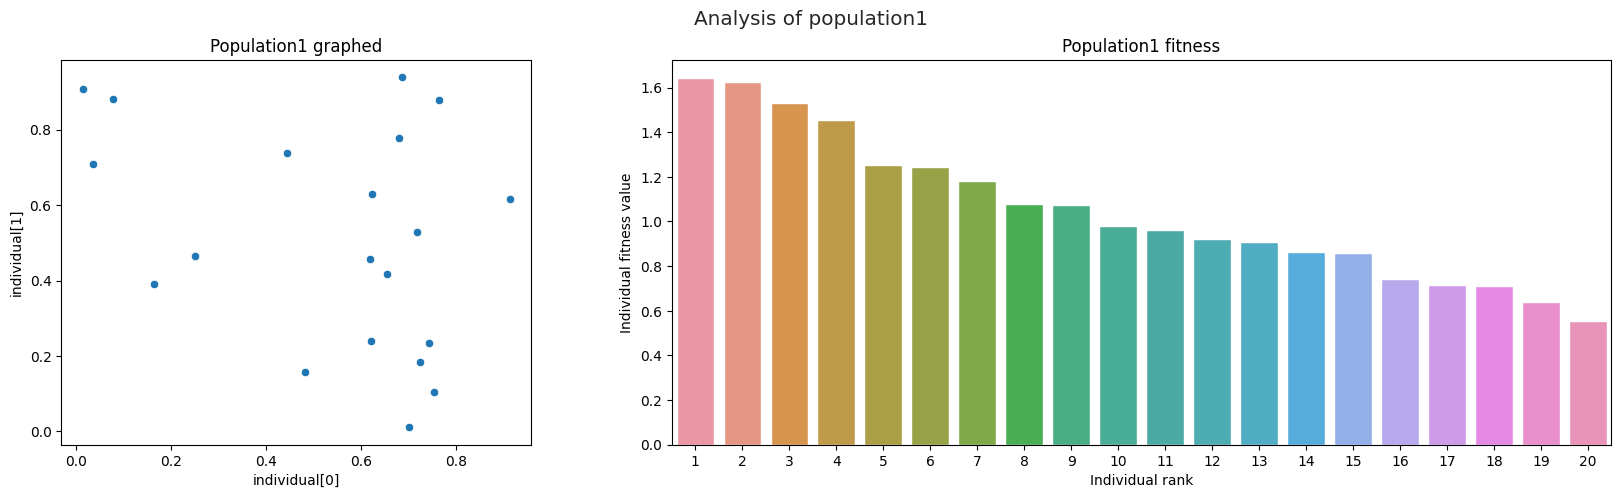

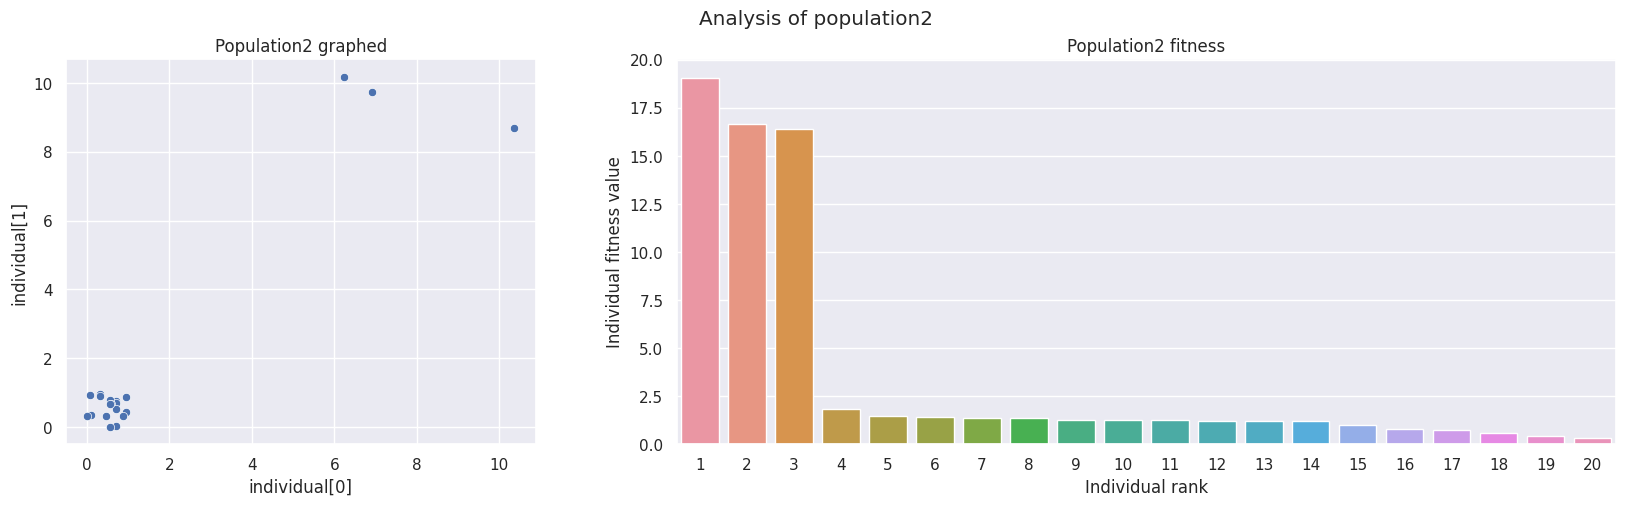

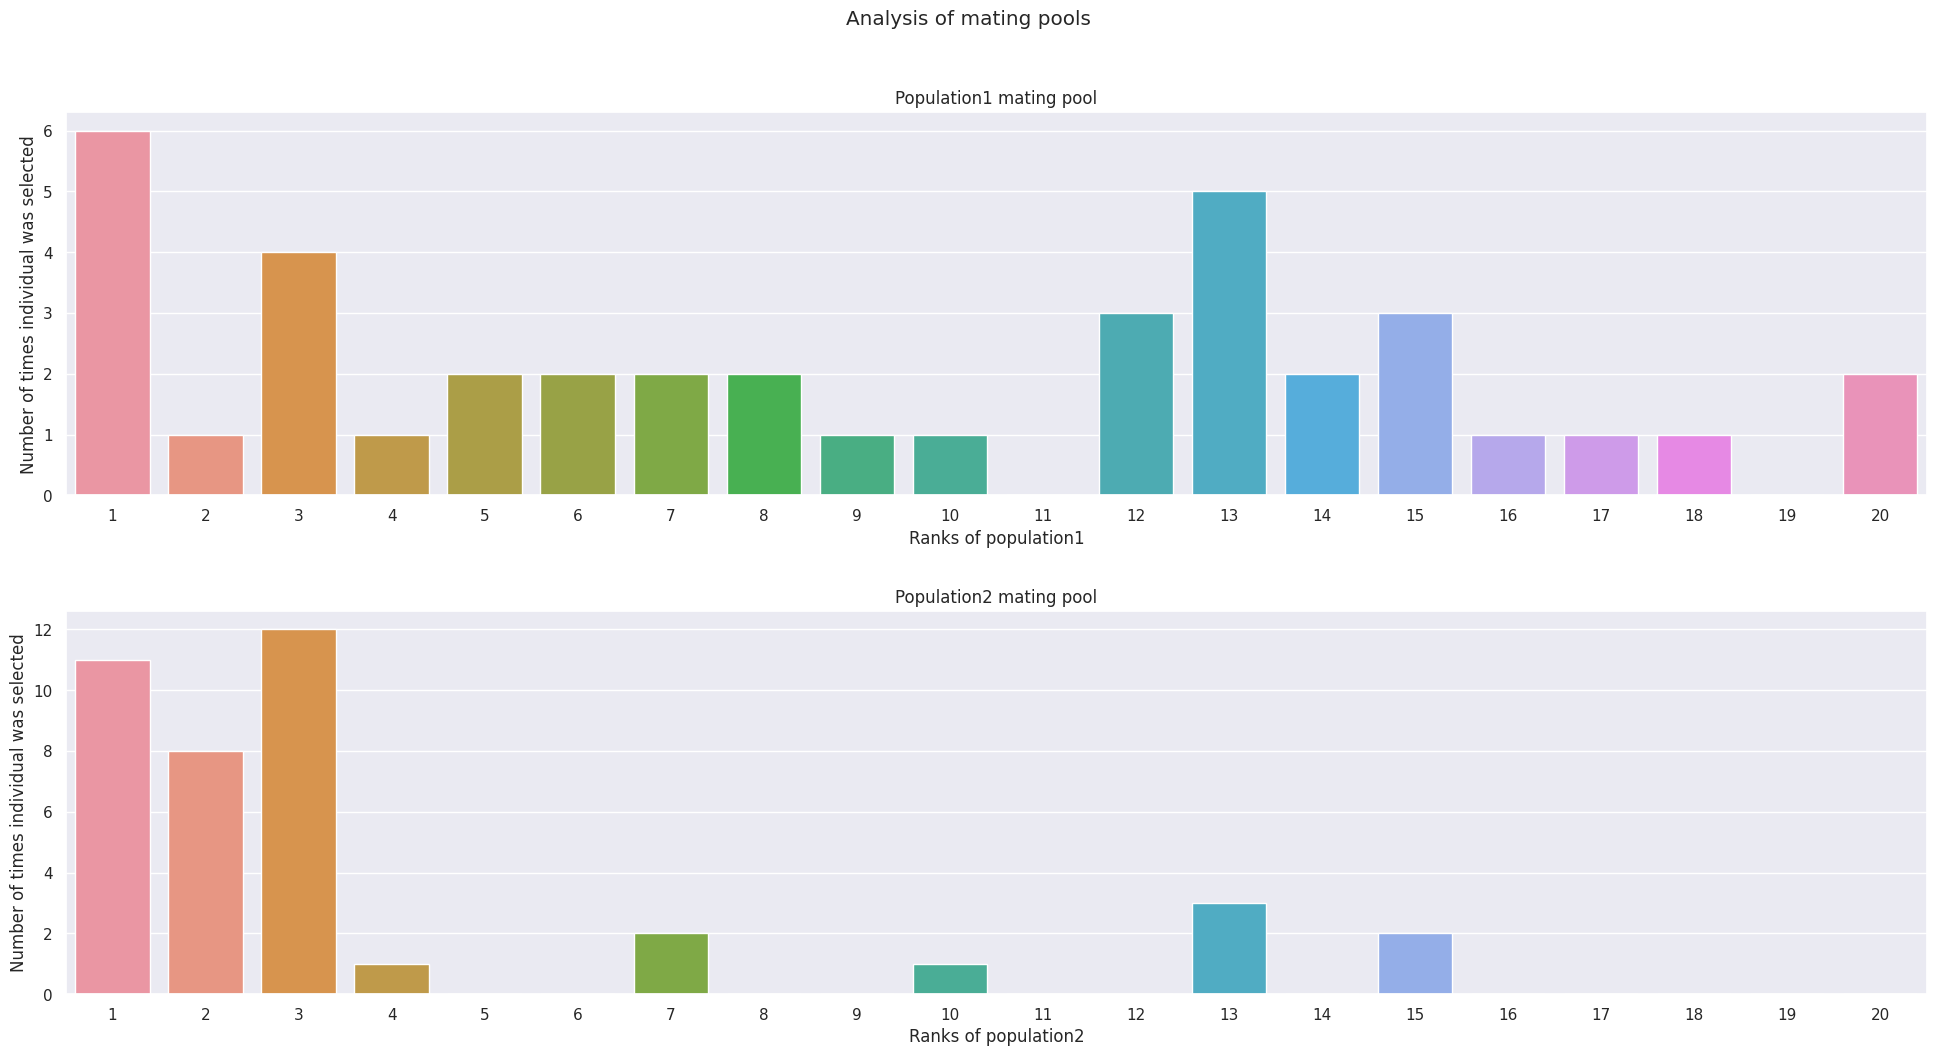

In [11]:
selection = Selection('demo')

number_of_individuals = 20
number_of_individuals_to_select = 40

fitness_function = lambda x: x[0] + x[1] #Simple fitness function, the bigger the sum of coordinates are, the better the individual is

fitness = Fitness(fitness_function, 2)

#Creating empty population
population1 = np.empty(shape=(number_of_individuals, 2))
population2 = np.empty(shape=(number_of_individuals, 2))

#Assigning random values [0, 1) to individuals
for individual in population1:
    individual[0] = random.random()
    individual[1] = random.random()
for individual in population2:
    individual[0] = random.random()
    individual[1] = random.random()

#Making first 3 individuals of population 2 be better than others
for individual in population2[-1:-4:-1]:
    individual[0] *= 12
    individual[1] *= 12

population1 = fitness.rank(population1)
population2 = fitness.rank(population2)

mating_pool1 = selection._scaled_roulette_wheel_selection(population1, fitness, number_of_individuals_to_select)
mating_pool2 = selection._scaled_roulette_wheel_selection(population2, fitness, number_of_individuals_to_select)

#Plotting population 1 info
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population1], y=[individual[1] for individual in population1], ax=axs1[0])
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=fitness.calculate_fitness(population1), ax=axs1[1])
fig1.suptitle('Analysis of population1')
axs1[0].set_title('Population1 graphed')
axs1[1].set_title('Population1 fitness')
axs1[0].set_xlabel('individual[0]')
axs1[0].set_ylabel('individual[1]')
axs1[1].set_xlabel('Individual rank')
axs1[1].set_ylabel('Individual fitness value')

#Plotting population 2 info
fig2, axs2 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population2], y=[individual[1] for individual in population2], ax=axs2[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=fitness.calculate_fitness(population2), ax=axs2[1])
fig2.suptitle('Analysis of population2')
axs2[0].set_title('Population2 graphed')
axs2[1].set_title('Population2 fitness')
axs2[0].set_xlabel('individual[0]')
axs2[0].set_ylabel('individual[1]')
axs2[1].set_xlabel('Individual rank')
axs2[1].set_ylabel('Individual fitness value')

#Counting every individual appearance in mating pool
appearance1 = np.empty(number_of_individuals)
appearance2 = np.empty(number_of_individuals)

for i in range(number_of_individuals):
    individual1 = population1[i]
    individual2 = population2[i]

    appearance1[i] = sum([x[0] == individual1[0] and x[1] == individual1[1] for x in mating_pool1])
    appearance2[i] = sum([x[0] == individual2[0] and x[1] == individual2[1] for x in mating_pool2])

#Plotting mating pool info
fig3, axs3 = plt.subplots(nrows=2, height_ratios=[1,1], figsize=(20, 11))
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=appearance1, ax=axs3[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=appearance2, ax=axs3[1])
fig3.suptitle('Analysis of mating pools')
axs3[0].set_title('Population1 mating pool')
axs3[1].set_title('Population2 mating pool')
axs3[0].set_xlabel('Ranks of population1')
axs3[0].set_ylabel('Number of times individual was selected')
axs3[1].set_xlabel('Ranks of population2')
axs3[1].set_ylabel('Number of times individual was selected')
fig3.tight_layout(pad=2.5)

In this example we are showing that populations with individuals with much greater fitness values will be susceptible to one individual occupying big portion of the mating pool. The opposite could happen too. If we have one really bad individual the weights of selecting others will be pretty close because everyone is much better than the last individual.

---
### <a id="ranking_selection">Ranking selection</a>
Ranking selection does not select individuals based on their fitness values. It sorts individuals by fitness value and looks at their rank and selects them by rank.<br>

Parameters:<br>
<b>max_rank_multiplier</b> is float that represents how many times the best individual will be more likely to be selected than the worst. After the best individual, the probability linearly drops with rank.

In [12]:
class Selection(Selection):
    def _ranking_selection(self, population: np.array, fitness: Fitness, number_of_individuals_to_select: int):
        max_rank_multiplier = self.params['max_rank_multiplier']
        population = fitness.rank(population)
        weights = ()
        for i in range(len(population)):
            weights += (round((1 - max_rank_multiplier)/(len(population) - 1) * i + max_rank_multiplier, 3), )
        
        return np.array(random.choices(population, weights, k=number_of_individuals_to_select))

#### Demo

As we can see from looking at how ranking selection works, if we know one individual is 10 times better than other individual it won't be 10 times more likely to be chosen. This could be both good and bad, because ranking selection does not take into account how much one individual is better or worse than another.

In the following example we will look at the two different populations. In the first one we have 3 really good individuals, in the second one, we have 3 really bad individuals. In both cases we are using the same fitness function.<br> 
$\text{fitness1}(x) = x[0] + x[1]$<br>

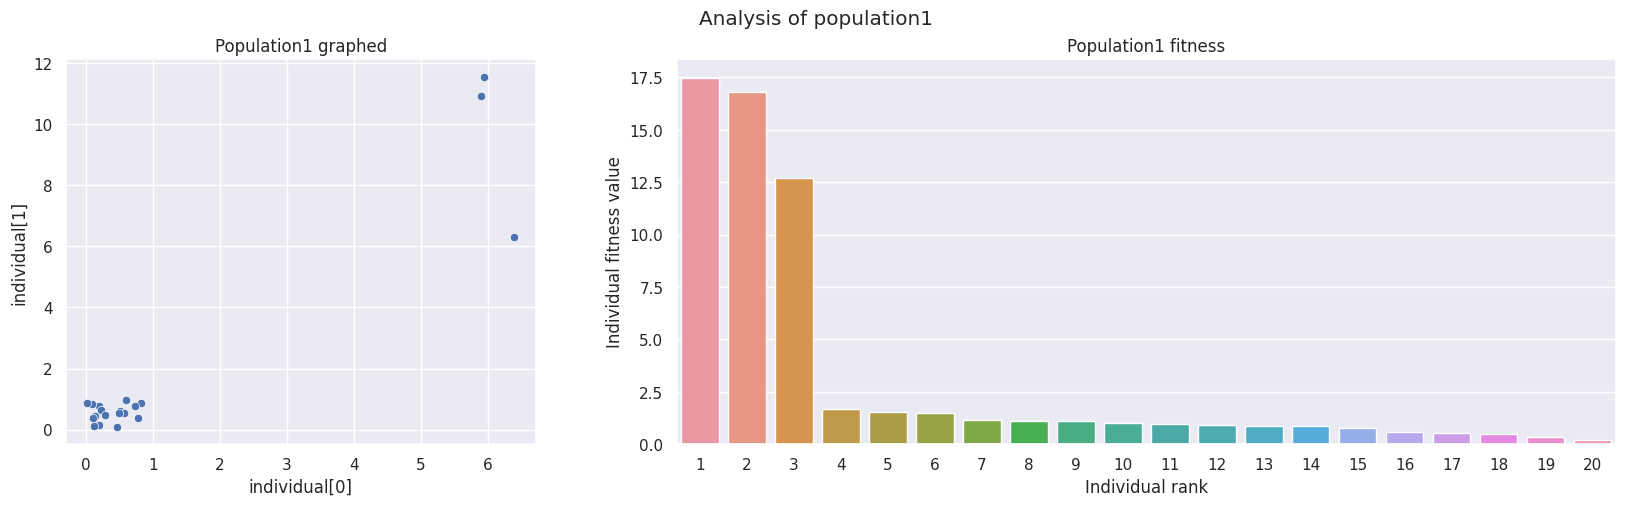

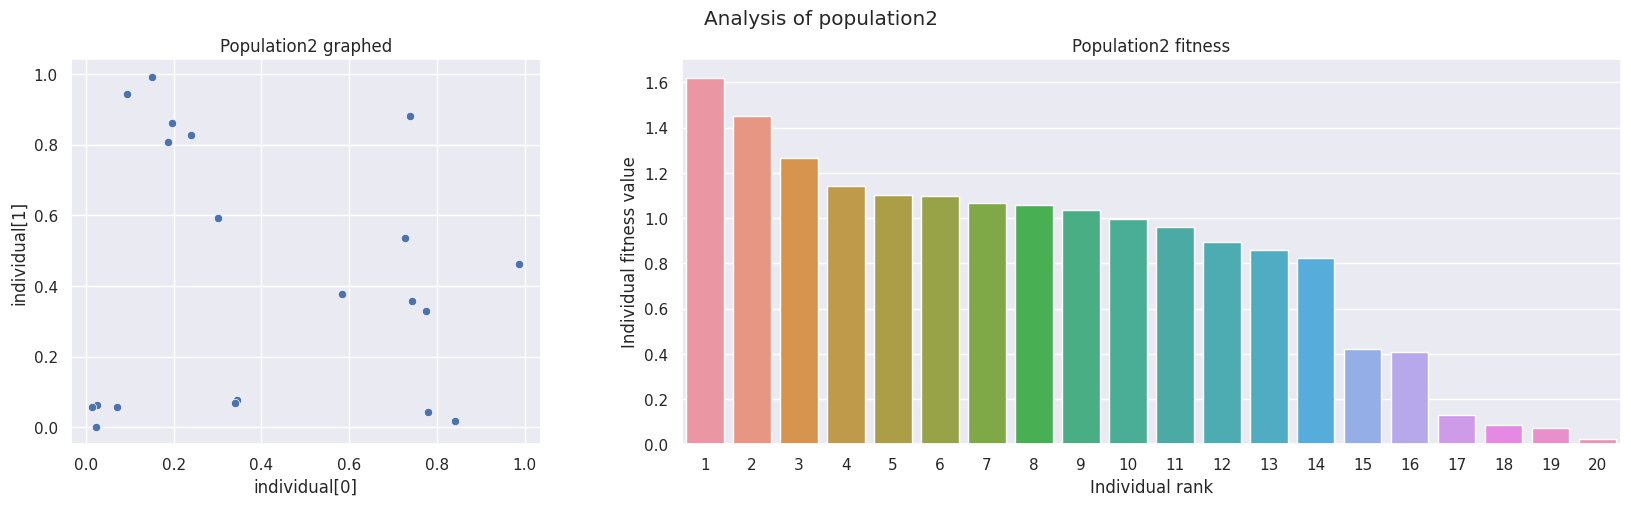

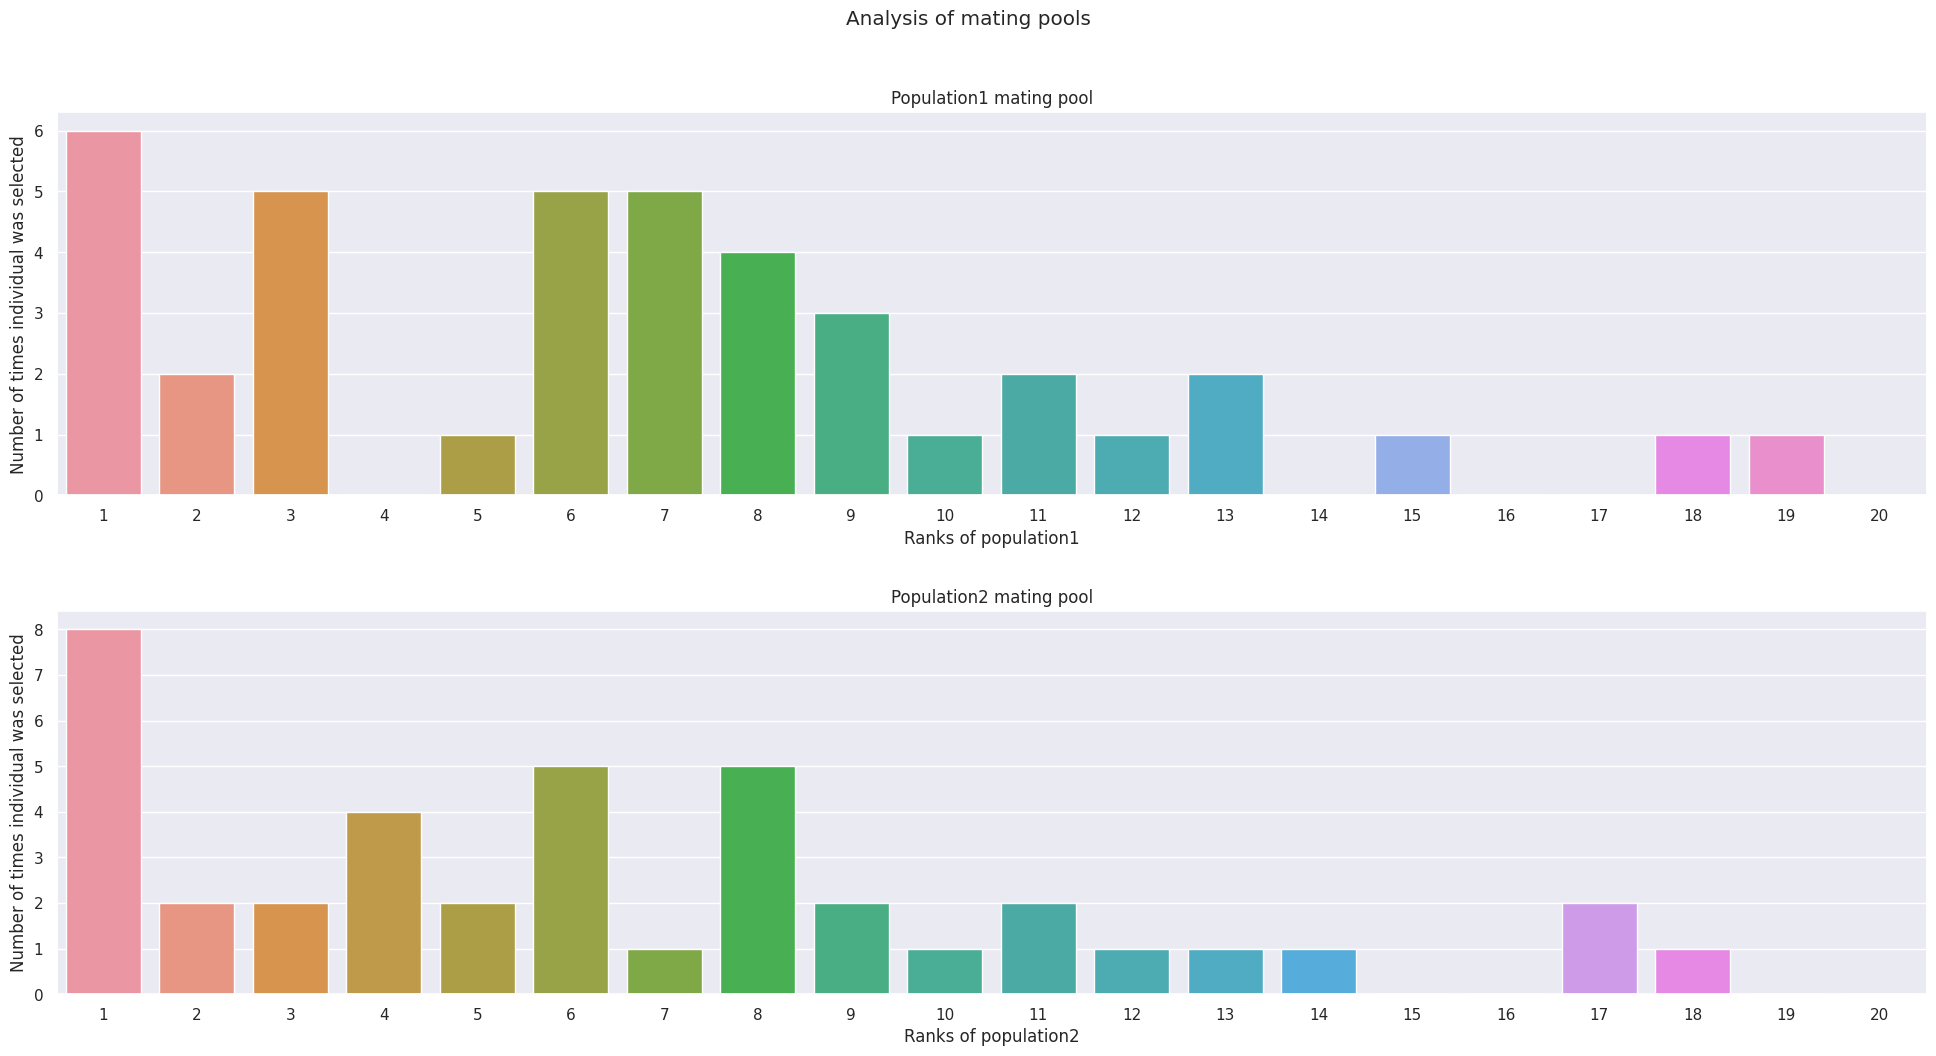

In [13]:
selection = Selection('demo')
selection.params = {}
selection.params['max_rank_multiplier'] = 20

number_of_individuals = 20
number_of_individuals_to_select = 40

fitness_function = lambda x: x[0] + x[1] #Simple fitness function, the bigger the sum of coordinates are, the better the individual is

fitness = Fitness(fitness_function, 2)

#Creating empty population
population1 = np.empty(shape=(number_of_individuals, 2))
population2 = np.empty(shape=(number_of_individuals, 2))

#Assigning random values [0, 1) to individuals
for individual in population1:
    individual[0] = random.random()
    individual[1] = random.random()
for individual in population2:
    individual[0] = random.random()
    individual[1] = random.random()

#Making 3 individuals of population 1 be better than others
for individual in population1[1:4]:
    individual[0] *= 12
    individual[1] *= 12

#Making 3 individuals of population 2 be worst than others
for individual in population2[1:4]:
    individual[0] /= 12
    individual[1] /= 12

population1 = fitness.rank(population1)
population2 = fitness.rank(population2)

mating_pool1 = selection._ranking_selection(population1, fitness, number_of_individuals_to_select)
mating_pool2 = selection._ranking_selection(population2, fitness, number_of_individuals_to_select)

#Plotting population 1 info
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population1], y=[individual[1] for individual in population1], ax=axs1[0])
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=fitness.calculate_fitness(population1), ax=axs1[1])
fig1.suptitle('Analysis of population1')
axs1[0].set_title('Population1 graphed')
axs1[1].set_title('Population1 fitness')
axs1[0].set_xlabel('individual[0]')
axs1[0].set_ylabel('individual[1]')
axs1[1].set_xlabel('Individual rank')
axs1[1].set_ylabel('Individual fitness value')

#Plotting population 2 info
fig2, axs2 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population2], y=[individual[1] for individual in population2], ax=axs2[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=fitness.calculate_fitness(population2), ax=axs2[1])
fig2.suptitle('Analysis of population2')
axs2[0].set_title('Population2 graphed')
axs2[1].set_title('Population2 fitness')
axs2[0].set_xlabel('individual[0]')
axs2[0].set_ylabel('individual[1]')
axs2[1].set_xlabel('Individual rank')
axs2[1].set_ylabel('Individual fitness value')

#Counting every individual appearance in mating pool
appearance1 = np.empty(number_of_individuals)
appearance2 = np.empty(number_of_individuals)

for i in range(number_of_individuals):
    individual1 = population1[i]
    individual2 = population2[i]

    appearance1[i] = sum([x[0] == individual1[0] and x[1] == individual1[1] for x in mating_pool1])
    appearance2[i] = sum([x[0] == individual2[0] and x[1] == individual2[1] for x in mating_pool2])

#Plotting mating pool info
fig3, axs3 = plt.subplots(nrows=2, height_ratios=[1,1], figsize=(20, 11))
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=appearance1, ax=axs3[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=appearance2, ax=axs3[1])
fig3.suptitle('Analysis of mating pools')
axs3[0].set_title('Population1 mating pool')
axs3[1].set_title('Population2 mating pool')
axs3[0].set_xlabel('Ranks of population1')
axs3[0].set_ylabel('Number of times individual was selected')
axs3[1].set_xlabel('Ranks of population2')
axs3[1].set_ylabel('Number of times individual was selected')
fig3.tight_layout(pad=2.5)

In this example we see that no matter how our populations look, if we have same max_rank_multiplier parameter mating pools will look really similar. Of course the more individuals we select, the bigger mating pool is, the more similar mating pools will look.

---
### <a id="tournament_selection">Tournament selection</a>
Tournament selection is a selection in which a small subset of individuals is chosen at random, and placed into a tournament. Only the best individual from tournament is chosen to be moved into the mating pool. This process is repeated until the mating pool is filled.

Parameters:<br>
<b>tournament_size</b> is integer that represents the number of individuals in the tournament.

In [14]:
class Selection(Selection):
    def _tournament_selection(self, population: np.array, fitness: Fitness, number_of_individuals_to_select: int):
        tournament_size = self.params['tournament_size']
        mating_pool = np.empty(shape=(number_of_individuals_to_select, population.shape[1]))
        population_fitness = fitness.calculate_fitness(population)
        population_size = len(population)
        for i in range(number_of_individuals_to_select):
            tournament_indexes = [random.randrange(population_size) for _ in range(tournament_size)]
            tournament_fitnesses = population_fitness[tournament_indexes]
            winner_index = max(enumerate(tournament_fitnesses), key=lambda x: x[1])[0]
            mating_pool[i] = population[tournament_indexes[winner_index]]
        return mating_pool

#### Demo

Same as the ranking selection, tournament selection also does not take into account how much better certain individuals are. As long as the individual wins the tournament it will be placed into the mating pool.

In the following example we have same populations and same fitness as in the ranking selection.<br>
First population have 3 really good individuals and the second population have 3 really bad individuals. Fitness is calculated by adding individuals coordinates.<br>
$\text{fitness1}(x) = x[0] + x[1]$<br>

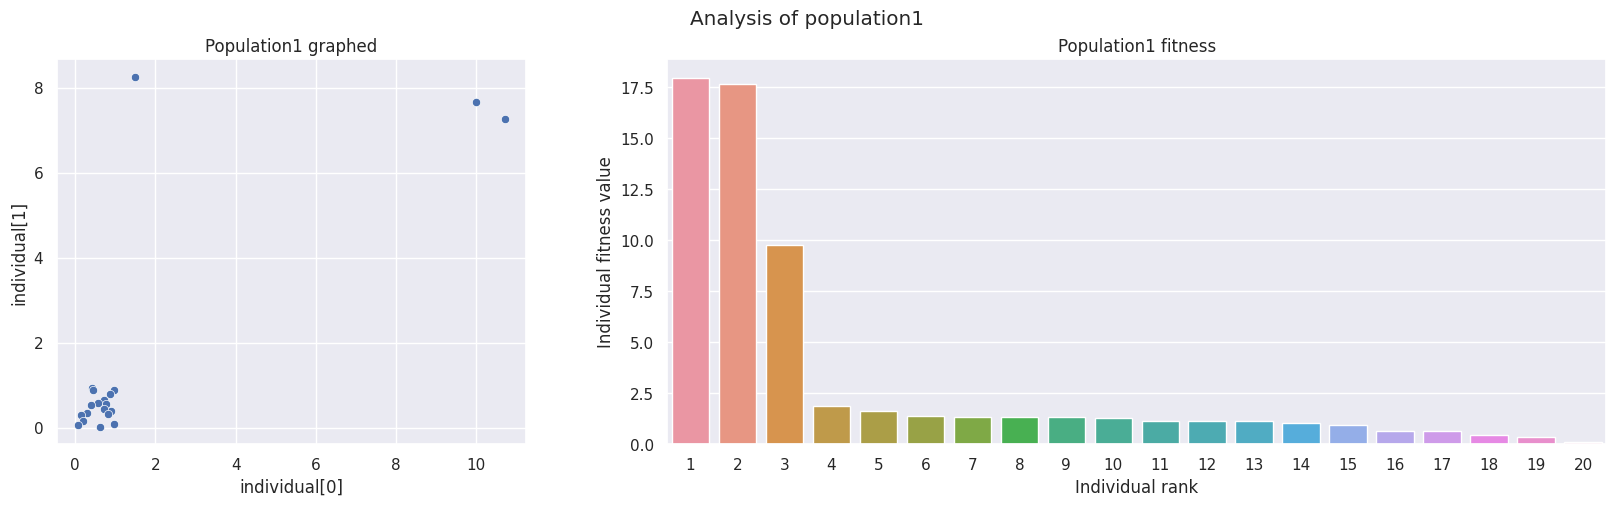

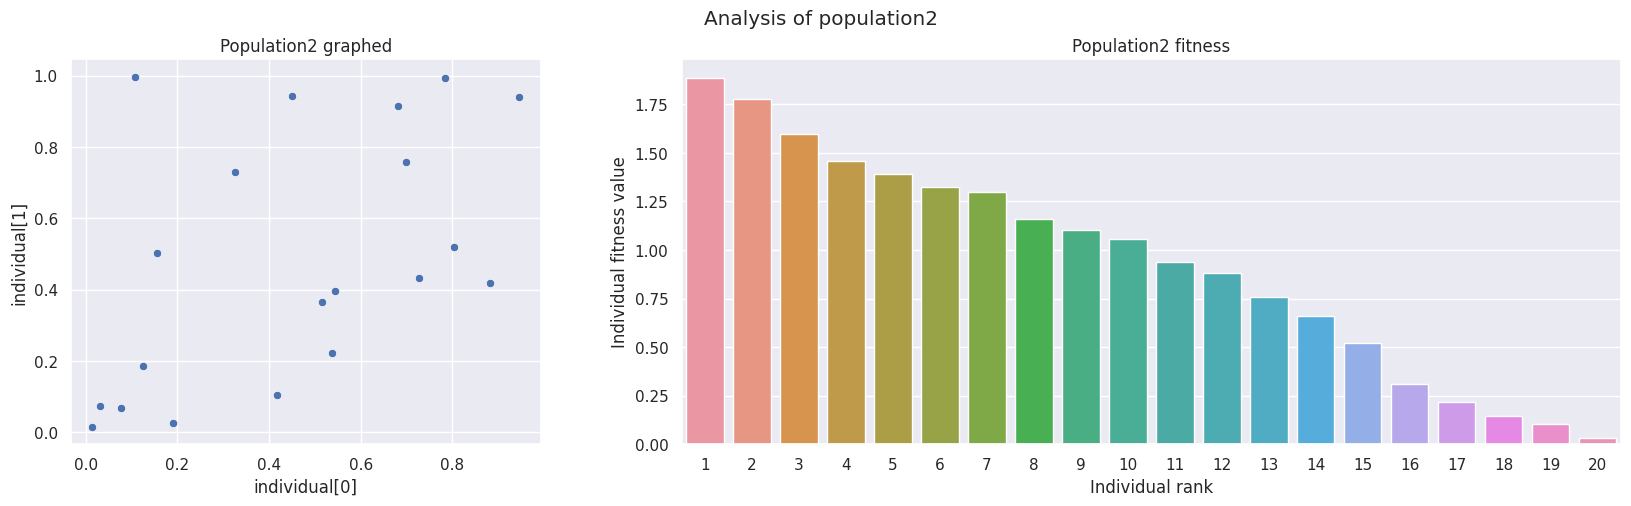

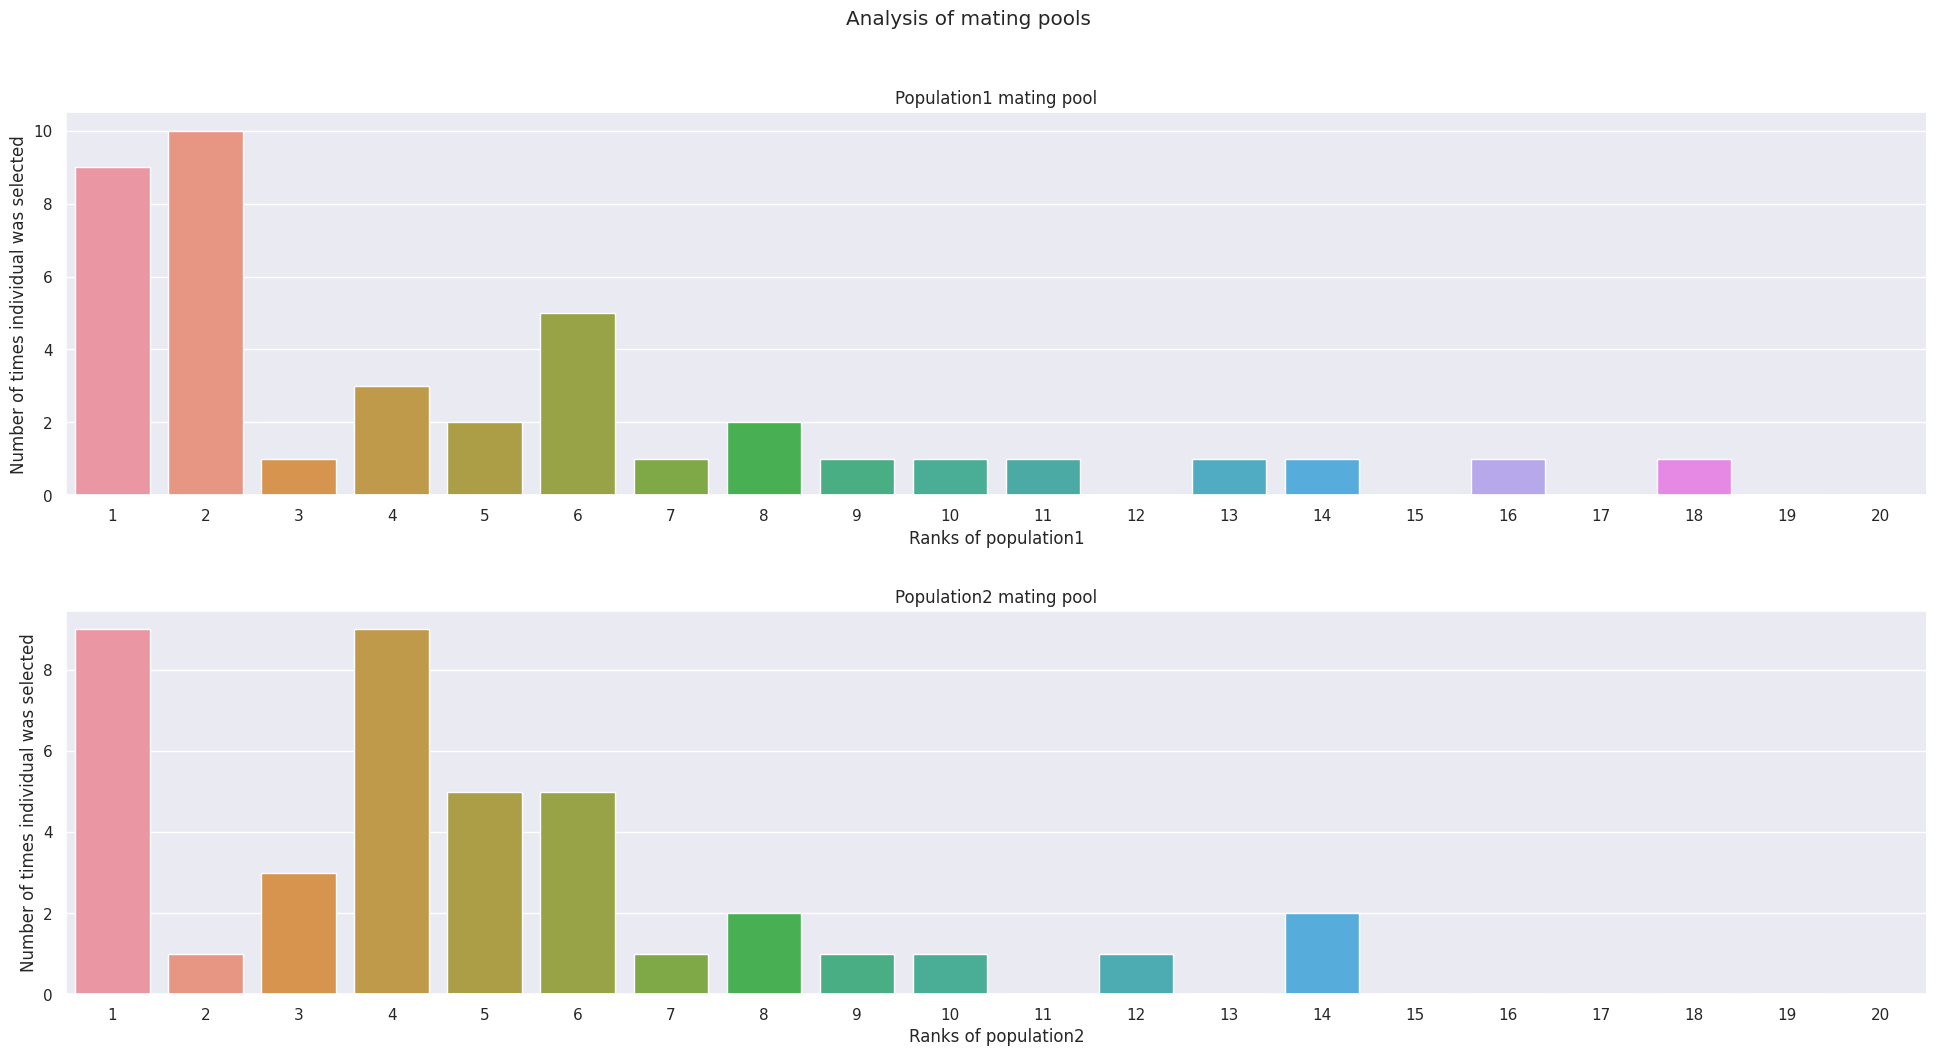

In [15]:
selection = Selection('demo')
selection.params = {}
selection.params['tournament_size'] = 3

number_of_individuals = 20
number_of_individuals_to_select = 40

fitness_function = lambda x: x[0] + x[1] #Simple fitness function, the bigger the sum of coordinates are, the better the individual is

fitness = Fitness(fitness_function, 2)

#Creating empty population
population1 = np.empty(shape=(number_of_individuals, 2))
population2 = np.empty(shape=(number_of_individuals, 2))

#Assigning random values [0, 1) to individuals
for individual in population1:
    individual[0] = random.random()
    individual[1] = random.random()
for individual in population2:
    individual[0] = random.random()
    individual[1] = random.random()

#Making 3 individuals of population 1 be better than others
for individual in population1[1:4]:
    individual[0] *= 12
    individual[1] *= 12

#Making 3 individuals of population 2 be worst than others
for individual in population2[1:4]:
    individual[0] /= 12
    individual[1] /= 12

population1 = fitness.rank(population1)
population2 = fitness.rank(population2)

mating_pool1 = selection._tournament_selection(population1, fitness, number_of_individuals_to_select)
mating_pool2 = selection._tournament_selection(population2, fitness, number_of_individuals_to_select)

#Plotting population 1 info
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population1], y=[individual[1] for individual in population1], ax=axs1[0])
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=fitness.calculate_fitness(population1), ax=axs1[1])
fig1.suptitle('Analysis of population1')
axs1[0].set_title('Population1 graphed')
axs1[1].set_title('Population1 fitness')
axs1[0].set_xlabel('individual[0]')
axs1[0].set_ylabel('individual[1]')
axs1[1].set_xlabel('Individual rank')
axs1[1].set_ylabel('Individual fitness value')

#Plotting population 2 info
fig2, axs2 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population2], y=[individual[1] for individual in population2], ax=axs2[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=fitness.calculate_fitness(population2), ax=axs2[1])
fig2.suptitle('Analysis of population2')
axs2[0].set_title('Population2 graphed')
axs2[1].set_title('Population2 fitness')
axs2[0].set_xlabel('individual[0]')
axs2[0].set_ylabel('individual[1]')
axs2[1].set_xlabel('Individual rank')
axs2[1].set_ylabel('Individual fitness value')

#Counting every individual appearance in mating pool
appearance1 = np.empty(number_of_individuals)
appearance2 = np.empty(number_of_individuals)

for i in range(number_of_individuals):
    individual1 = population1[i]
    individual2 = population2[i]

    appearance1[i] = sum([x[0] == individual1[0] and x[1] == individual1[1] for x in mating_pool1])
    appearance2[i] = sum([x[0] == individual2[0] and x[1] == individual2[1] for x in mating_pool2])

#Plotting mating pool info
fig3, axs3 = plt.subplots(nrows=2, height_ratios=[1,1], figsize=(20, 11))
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=appearance1, ax=axs3[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=appearance2, ax=axs3[1])
fig3.suptitle('Analysis of mating pools')
axs3[0].set_title('Population1 mating pool')
axs3[1].set_title('Population2 mating pool')
axs3[0].set_xlabel('Ranks of population1')
axs3[0].set_ylabel('Number of times individual was selected')
axs3[1].set_xlabel('Ranks of population2')
axs3[1].set_ylabel('Number of times individual was selected')
fig3.tight_layout(pad=2.5)

The conclusion is the same as with the ranking population: no matter the fitness values, the mating pool will look similar.

---
### <a id="random_selection">Random selection</a>
Random selection is only non biased selection that chooses parents on random without and knowledge about their performance.

In [16]:
class Selection(Selection):
    def _random_selection(self, population: np.array, fitness: Fitness, number_of_individuals_to_select: int):
        return np.array(random.choices(population, k=number_of_individuals_to_select))

#### Demo

Random selection is in this project just so we can compare different selections to the basic case. Neither fitness nor individual rank are taken into account in random selection.

In the next example we have 2 populations. One is totally random, second is with 3 really good individuals. Fitness function is the sum of the individuals coordinates.

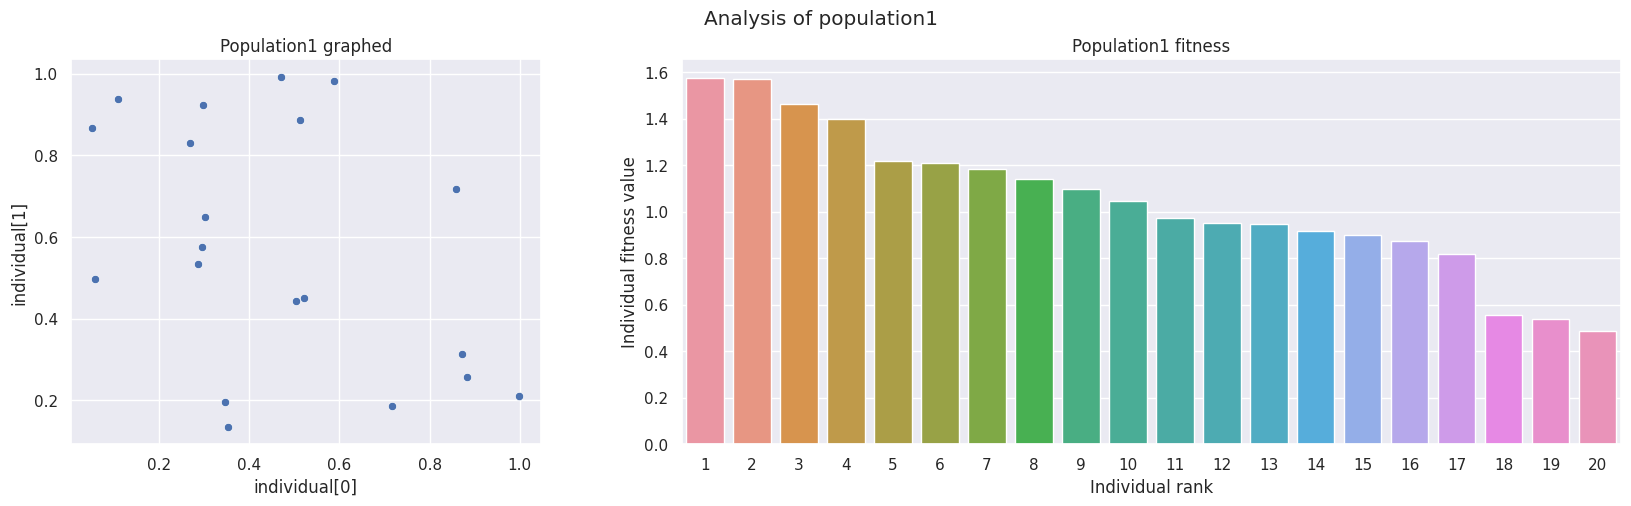

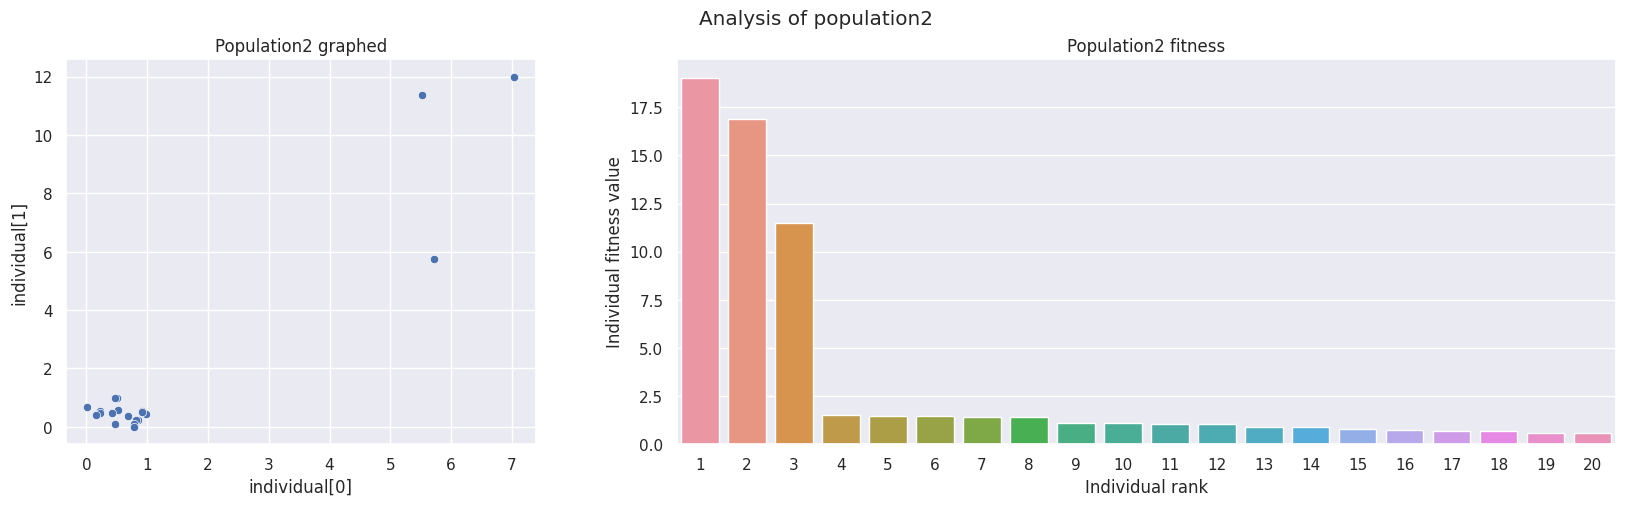

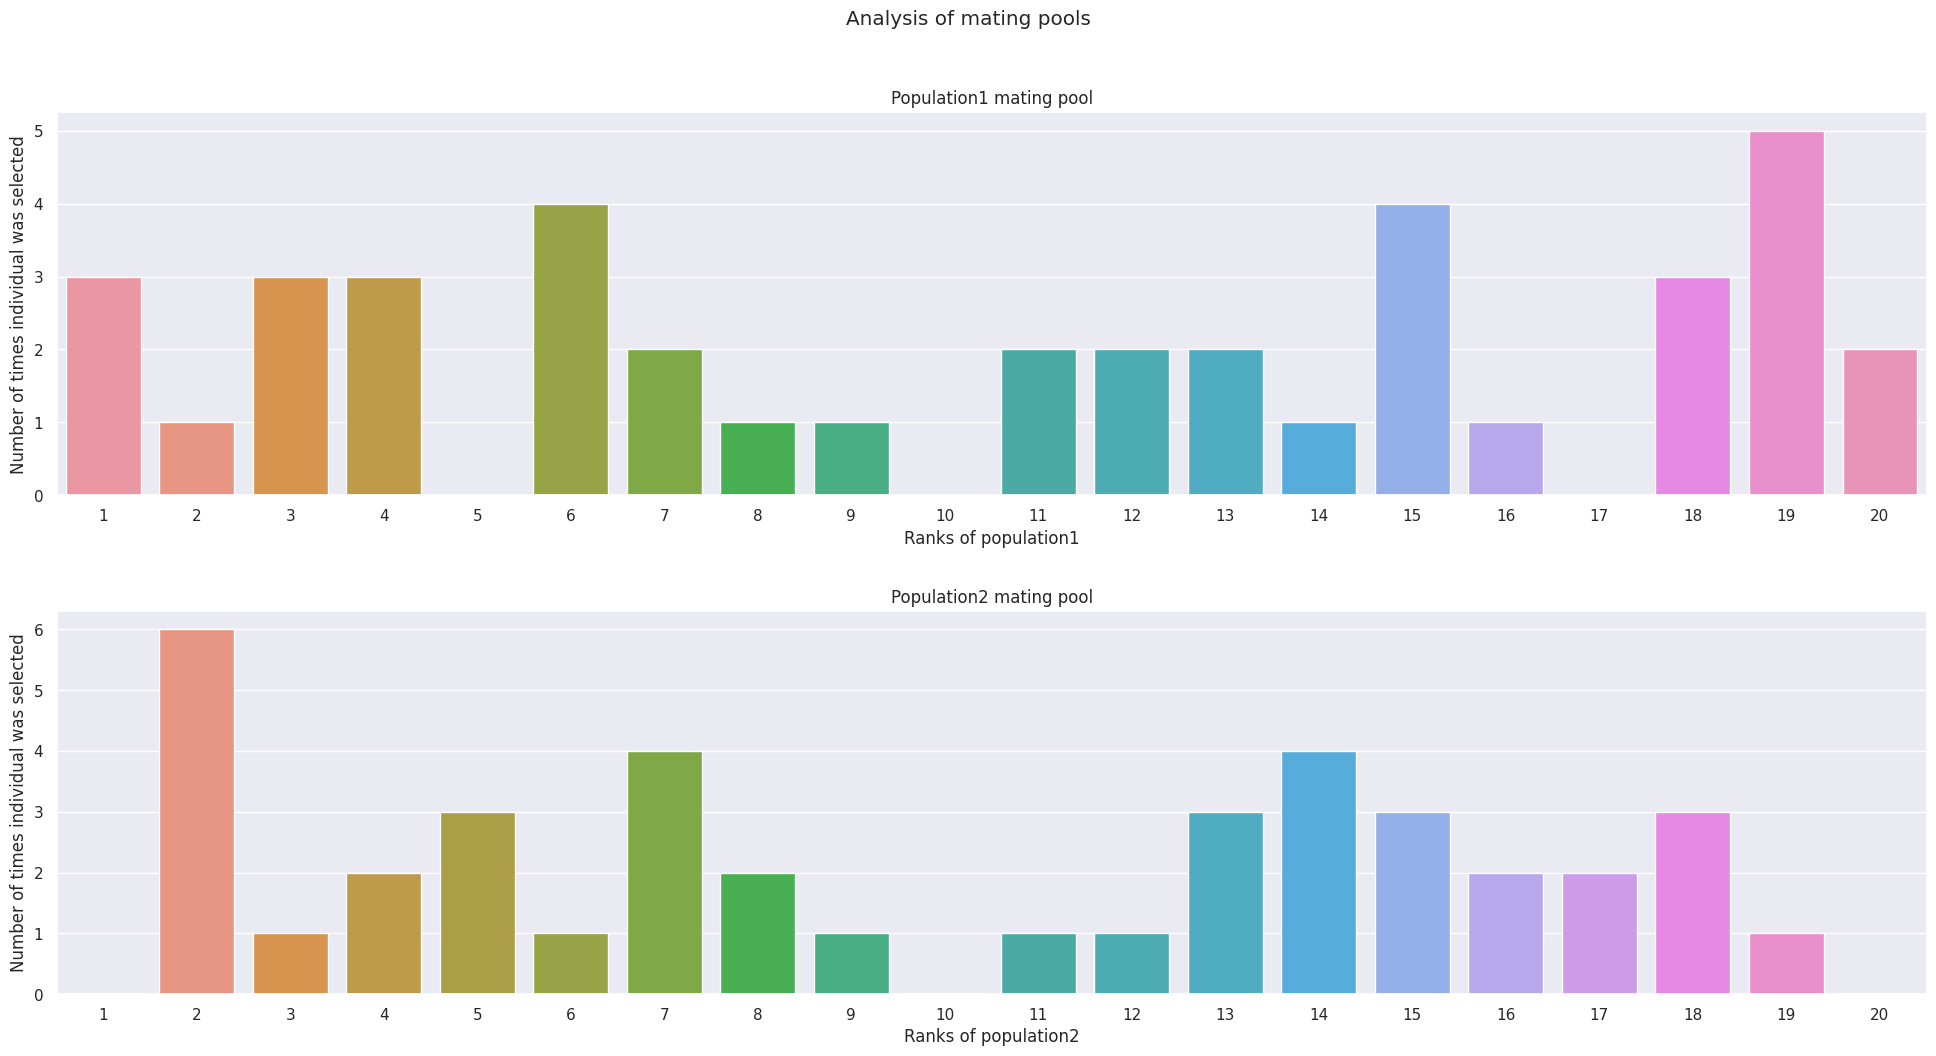

In [17]:
selection = Selection('demo')

number_of_individuals = 20
number_of_individuals_to_select = 40

fitness_function = lambda x: x[0] + x[1] #Simple fitness function, the bigger the sum of coordinates are, the better the individual is

fitness = Fitness(fitness_function, 2)

#Creating empty population
population1 = np.empty(shape=(number_of_individuals, 2))
population2 = np.empty(shape=(number_of_individuals, 2))

#Assigning random values [0, 1) to individuals
for individual in population1:
    individual[0] = random.random()
    individual[1] = random.random()
for individual in population2:
    individual[0] = random.random()
    individual[1] = random.random()

#Making first 3 individuals of population 2 be better than others
for individual in population2[-1:-4:-1]:
    individual[0] *= 12
    individual[1] *= 12

population1 = fitness.rank(population1)
population2 = fitness.rank(population2)

mating_pool1 = selection._random_selection(population1, fitness, number_of_individuals_to_select)
mating_pool2 = selection._random_selection(population2, fitness, number_of_individuals_to_select)

#Plotting population 1 info
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population1], y=[individual[1] for individual in population1], ax=axs1[0])
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=fitness.calculate_fitness(population1), ax=axs1[1])
fig1.suptitle('Analysis of population1')
axs1[0].set_title('Population1 graphed')
axs1[1].set_title('Population1 fitness')
axs1[0].set_xlabel('individual[0]')
axs1[0].set_ylabel('individual[1]')
axs1[1].set_xlabel('Individual rank')
axs1[1].set_ylabel('Individual fitness value')

#Plotting population 2 info
fig2, axs2 = plt.subplots(ncols=2, width_ratios=[1, 2], figsize=(20, 5))
sns.set_theme(style='darkgrid', context='notebook')
sns.scatterplot(x=[individual[0] for individual in population2], y=[individual[1] for individual in population2], ax=axs2[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=fitness.calculate_fitness(population2), ax=axs2[1])
fig2.suptitle('Analysis of population2')
axs2[0].set_title('Population2 graphed')
axs2[1].set_title('Population2 fitness')
axs2[0].set_xlabel('individual[0]')
axs2[0].set_ylabel('individual[1]')
axs2[1].set_xlabel('Individual rank')
axs2[1].set_ylabel('Individual fitness value')

#Counting every individual appearance in mating pool
appearance1 = np.empty(number_of_individuals)
appearance2 = np.empty(number_of_individuals)

for i in range(number_of_individuals):
    individual1 = population1[i]
    individual2 = population2[i]

    appearance1[i] = sum([x[0] == individual1[0] and x[1] == individual1[1] for x in mating_pool1])
    appearance2[i] = sum([x[0] == individual2[0] and x[1] == individual2[1] for x in mating_pool2])

#Plotting mating pool info
fig3, axs3 = plt.subplots(nrows=2, height_ratios=[1,1], figsize=(20, 11))
sns.barplot(x=[str(i) for i in range(1, len(population1) + 1)], y=appearance1, ax=axs3[0])
sns.barplot(x=[str(i) for i in range(1, len(population2) + 1)], y=appearance2, ax=axs3[1])
fig3.suptitle('Analysis of mating pools')
axs3[0].set_title('Population1 mating pool')
axs3[1].set_title('Population2 mating pool')
axs3[0].set_xlabel('Ranks of population1')
axs3[0].set_ylabel('Number of times individual was selected')
axs3[1].set_xlabel('Ranks of population2')
axs3[1].set_ylabel('Number of times individual was selected')
fig3.tight_layout(pad=2.5)

## Selection class

In [18]:
class Selection(Selection):
    VALID_SELECTION_STRATS = ['roulette',
                              'scroulette',
                              'ranking',
                              'tournament',
                              'random']
    DEFAULT_MAX_RANK_MULTIPLIER = 20
    DEFAULT_TOURNAMENT_SIZE = 3
    def get_possible_strats(self):
        return str(self.VALID_SELECTION_STRATS)
        
    def _check_strat(self, selection_strat: str):
        if not selection_strat in self.VALID_SELECTION_STRATS:
            raise ValueError('Seleciton strategy name is not recognised, you can use selection_strat=' + self.get_possible_strats())

    def _set_selection(self, selection_strat: str, **kwargs):
        if(selection_strat == 'roulette'):
            self._selection = self._roulette_wheel_selection
            
        elif(selection_strat == 'scroulette'):
            self._selection = self._scaled_roulette_wheel_selection
        
        elif(selection_strat == 'ranking'):
            self._selection = self._ranking_selection
            check_parameter(self, 'max_rank_multiplier', 'ranking', 'selection', self.DEFAULT_MAX_RANK_MULTIPLIER, (int, float), kwargs)
            self.params['max_rank_multiplier'] = float(self.params['max_rank_multiplier'])
            
        elif(selection_strat == 'tournament'):
            self._selection = self._tournament_selection
            check_parameter(self, 'tournament_size', 'tournament', 'selection', self.DEFAULT_TOURNAMENT_SIZE, (int), kwargs)
        
        elif(selection_strat == 'random'):
            self._selection = self._random_selection
        
        else:
            raise AssertionError('Selection strategy name exist in the valid selection strategies but was not found')
    
    def __init__(self, selection_strat: str, *, tournament_size=None, max_rank_multiplier=None):
        self._selection_strat = selection_strat
        self._check_strat(selection_strat)
        self._set_selection(selection_strat, tournament_size=tournament_size, max_rank_multiplier=max_rank_multiplier)

    def select_mating_pool(self, population: np.array, fitness: Fitness, number_of_individuals_to_select: int) -> np.array:
        #Check if fitness is callable
        return self._selection(population, fitness, number_of_individuals_to_select)

    def get_info(self):
        return f'Selection strategy - {self._selection_strat} with next parameters:'+ ('\n\t'.join("{0} = {1}".format(key, value)  for key,value in self.params.items()) if self.params.items() else f'\n\tMethod have no parameters') 

## Crossover

Crossover also called recombination is process of combining individuals to produce new individuals. This process requires mating pool, and produces offspring population.

In [19]:
class Crossover():
    #This is not constructor intended to be used if you are not debugging or expanding library
    def __init__(self, mode: str):
        valid = ['debug', 'demo']
        if not mode in valid:
            raise ValueError('Unknown mode')

Types of crossover implemented:
- [Symmetrical crossover](#symmetrical_crossover)
- [Linear crossover](#linear_crossover)
- [Bland crossover](#blx)
- [SBX](#sbx) (<u>S</u>imulated <u>B</u>inary Crossover)

---
### <a id="symmetrical_crossover">Symmetrical crossover</a>
Given the parents $x_1$ and $x_2$ the children $y_1$ and $y_2$ are:<br>
$y_1 = \Omega * x_1 + (1-\Omega) * x_2$ and $y_2 = \Omega * x_2 + (1-\Omega) * x_1$ where $\Omega$ is a random float between 0 and 1.<br>
If $x_1$ and $x_2$ are multidimensional then this process is repeated for every dimension.<br>
Symmetrical crossover from $\lambda$ individuals produces $\lambda$ offspring.

In [20]:
class Crossover(Crossover):
    def _symmetrical_crossover(self, mating_pool: np.array, fitness: Fitness):
        sistem_size = len(mating_pool[0])
        offspring = np.empty(shape=mating_pool.shape)
        
        for i in range(0, len(mating_pool), 2):
            parent1 = mating_pool[i]
            parent2 = mating_pool[i+1]
            child1 = np.empty(sistem_size)
            child2 = np.empty(sistem_size)
            omega = random.random()
            for j in range(sistem_size):
                child1[j] = parent1[j] * omega + parent2[j] * (1 - omega)
                child2[j] = parent1[j] * (1 - omega) + parent2[j] * omega
            offspring[i] = child1
            offspring[i+1] = child2
        return offspring

#### Demo

The bad thing with this approach is that the two new individuals will always be between the parents, there is no way for them to explore area outside area limited by their parents.

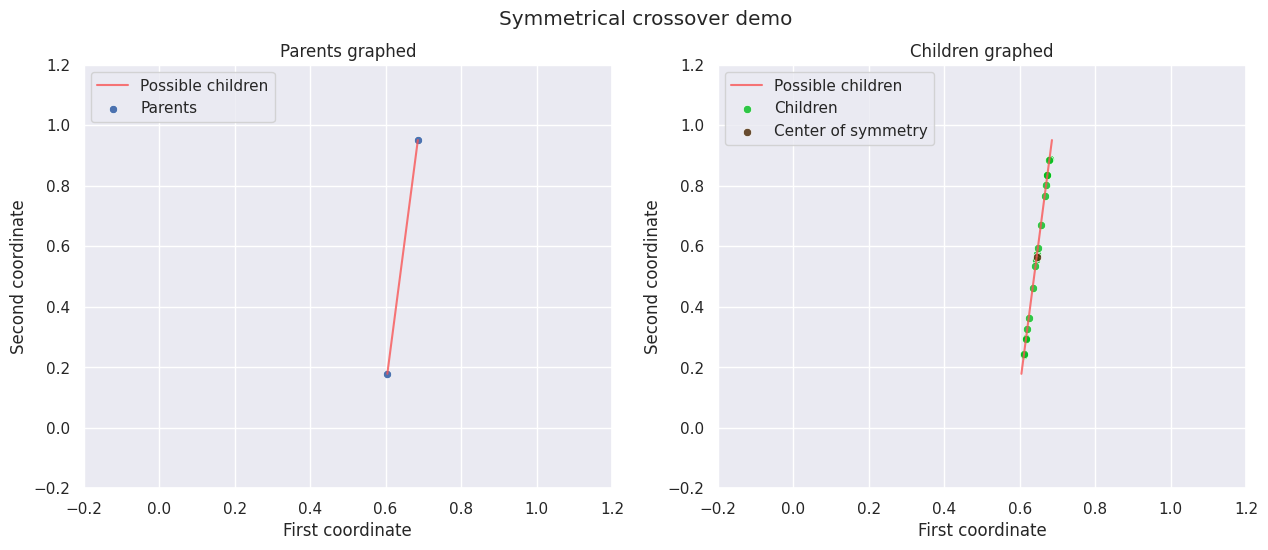

In [21]:
crossover = Crossover('demo')

sistem_size = 2

parent1 = np.empty(sistem_size)
parent2 = np.empty(sistem_size)

for i in range(sistem_size):
    parent1[i] = random.random()
    parent2[i] = random.random()

number_of_tries = 10 #10 times we will do crossover between this parents, that means we will produce 20 children

children = np.array([[-10, -10]])#[-10, -10] is placeholder to give array a shape of (1, 2)
for _ in range(number_of_tries):
    offspring = crossover._symmetrical_crossover(mating_pool=np.array([parent1, parent2]), fitness=None)#This approach does not use fitness so it is ok to pass None
    children = np.append(children, offspring, axis=0)

#center of the possible children line
center = (parent1 + parent2) / 2

#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')

axs1[0].plot([individual[0] for individual in [parent1, parent2]], [individual[1] for individual in [parent1, parent2]], label='Possible children', color=(249/255.0, 86/255.0, 86/255.0, 0.8))
sns.scatterplot(x=[individual[0] for individual in [parent1, parent2]], y=[individual[1] for individual in [parent1, parent2]], ax=axs1[0], label='Parents')

axs1[1].plot([individual[0] for individual in [parent1, parent2]], [individual[1] for individual in [parent1, parent2]], label='Possible children', color=(249/255.0, 86/255.0, 86/255.0, 0.8))
sns.scatterplot(x=[individual[0] for individual in children], y=[individual[1] for individual in children], ax=axs1[1], label='Children', color=(0/255, 190/255, 28/255, 0.8))
sns.scatterplot(x=[center[0]], y=[center[1]], label='Center of symmetry', color=(72/255, 37/255, 0/255, 0.8))


axs1[0].legend(loc=2)
axs1[1].legend(loc=2)

axs1[0].set_xlim([-0.2, 1.2])
axs1[0].set_ylim([-0.2, 1.2])

axs1[1].set_xlim([-0.2, 1.2])
axs1[1].set_ylim([-0.2, 1.2])

fig1.suptitle('Symmetrical crossover demo')
axs1[0].set_title('Parents graphed')
axs1[1].set_title('Children graphed')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')
pass

From the following example we see that when we use symmetrical crossover children will lay on the line that connects parents. Also if we look at the second graph, we have plotted center of the possible children line, and we see that the sides of that line are symmetrical.

---
### <a id="linear_crossover">Linear crossover</a>
Given the parents $x_1$ and $x_2$ the offspring $y_1$ and $y_2$ are:<br>
$k_1 = 0,5 * x_1 + 0,5 * x_2$<br>
$k_2 = -0,5 * x_1 + 1,5 * x_2$<br>
$k_3 = 1,5 * x_1 - 0,5 * x_2$<br>
$y_1$ and $y_2$ are the two best individuals from $\{k_1, k_2, k_3\}$ based on their fitness values.<br>
If the individual is multidimensional then you can look at the $x_1$ and $x_2$ as vectors and use respective vector operators.<br>
Linear crossover from $\lambda$ individuals produces $\lambda$ offspring.

In [22]:
class Crossover(Crossover):
    def _linear_crossover(self, mating_pool: np.array, fitness: Fitness):
        sistem_size = len(mating_pool[0])
        offspring = np.empty(shape=mating_pool.shape)

        for i in range(0, len(mating_pool), 2):
            parent1 = mating_pool[i]
            parent2 = mating_pool[i+1]
            child1 = np.empty(sistem_size)
            child2 = np.empty(sistem_size)
            child3 = np.empty(sistem_size)
            for j in range(sistem_size):
                child1[j] =  0.5 * parent1[j] + 0.5 * parent2[j]
                child2[j] = -0.5 * parent1[j] + 1.5 * parent2[j]
                child3[j] =  1.5 * parent1[j] - 0.5 * parent2[j]
                
            offspring[i:i+2] = sorted([child1, child2, child3], key=fitness.function, reverse=True)[0:2]

        return offspring

#### Demo

Linear crossover can not produce a lot of individuals from the same parents.

In the following example we will look at the two random parents, and using linear crossover we will create 2 children.

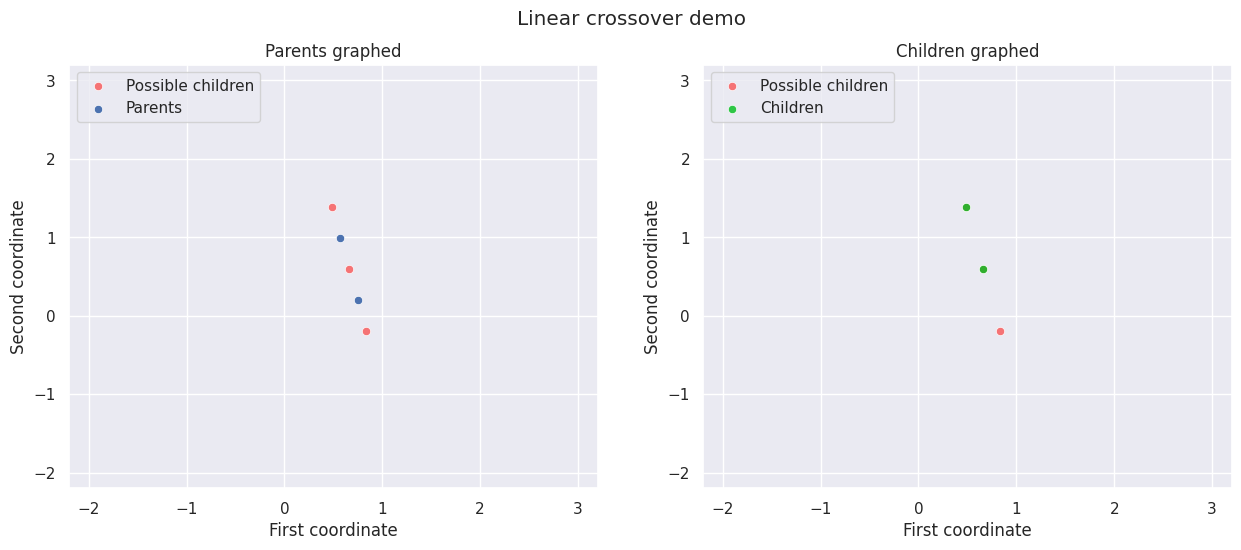

In [23]:
crossover = Crossover('demo')

system_size = 2

parent1 = np.empty(system_size)
parent2 = np.empty(system_size)

for i in range(sistem_size):
    parent1[i] = random.random()
    parent2[i] = random.random()

#This crossover need fitness
fitness_function = lambda x: x[0] + x[1]#The bigger the sum of individuals coordinates is, the better the individual is
fitness = Fitness(fitness_function, system_size)

offspring = crossover._linear_crossover(mating_pool=np.array([parent1, parent2]), fitness=fitness)

#Calculating where the possible children can bee
possible_children = []
possible_children.append(0.5 * parent1 + 0.5 * parent2)
possible_children.append(-0.5 * parent1 + 1.5 * parent2)
possible_children.append(1.5 * parent1 - 0.5 * parent2)


#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')

sns.scatterplot(x=[individual[0] for individual in possible_children], y=[individual[1] for individual in possible_children], ax=axs1[0], label='Possible children', color=(249/255.0, 86/255.0, 86/255.0, 0.8))
sns.scatterplot(x=[individual[0] for individual in [parent1, parent2]], y=[individual[1] for individual in [parent1, parent2]], ax=axs1[0], label='Parents')

sns.scatterplot(x=[individual[0] for individual in possible_children], y=[individual[1] for individual in possible_children], ax=axs1[1], label='Possible children', color=(249/255.0, 86/255.0, 86/255.0, 0.8))
sns.scatterplot(x=[individual[0] for individual in offspring], y=[individual[1] for individual in offspring], ax=axs1[1], label='Children', color=(0/255, 190/255, 28/255, 0.8))

axs1[0].legend(loc=2)
axs1[1].legend(loc=2)

axs1[0].set_xlim([-2.2, 3.2])
axs1[0].set_ylim([-2.2, 3.2])

axs1[1].set_xlim([-2.2, 3.2])
axs1[1].set_ylim([-2.2, 3.2])

fig1.suptitle('Linear crossover demo')
axs1[0].set_title('Parents graphed')
axs1[1].set_title('Children graphed')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')
pass

Unlike with the symmetrical crossover we can not produce a lot of children with two parents. Linear crossover have 3 possible children. The good part about this is that 2 children are not in between the parents, however linear crossover can give bad children when parents are far away from each other.<br>
Also it is possible to look at the parent individuals as the offspring and choose 2 best individuals from the 3 children and 2 parents. In this case it is possible for parents to survive crossover.

---
### <a id="blx">Bland crossover</a>
Given the parents $x_1$ and $x_2$ the offspring $y_1$ is:<br>
$y_1 = random([min(x_1, x_2) - \alpha * |x_1 - x_2|, max(x_1, x_2) + \alpha * |x_1 - x_2|])$<br>
$\alpha$ is parameter of the algorithm, 0.5 is usually OK<br>
This algorithm can produce desired number of offspring from the two parents but in this implementation, due the simplicity it will return two offspring.<br>
It the individual is multidimensional then, this process is repeated for every dimension so if $y_1 = [y_{11}\ y_{12}\ ...\ y_{1n}]^T$ then:<br> $y_{1i} = \sum \limits _{i=1} ^{n}random([min(x_1i, x_2i) - \alpha * |x_1i - x_2i|, max(x_1i, x_2i) + \alpha * |x_1i - x_2i|]) $<br>
$random([a, b])$ represents choosing one random float from the range $[a, b]$<br>
Bland crossover from $\lambda$ individuals produces $\lambda$ offspring.

Parameters:<br>
$\alpha$ is float parameter that represents how far away from parent individuals the offspring can be. The greater the value the bigger potential area offspring can be in.

In [24]:
class Crossover(Crossover):
    def _bland_crossover(self, mating_pool: np.array, fitness: Fitness):
        sistem_size = len(mating_pool[0])
        offspring = np.empty(shape=mating_pool.shape)
        alpha = self.params['alpha']
        
        for i in range(0, len(mating_pool), 2):
            parent1 = mating_pool[i]
            parent2 = mating_pool[i+1]
            child1 = np.empty(sistem_size)
            child2 = np.empty(sistem_size)
            for j in range(sistem_size):
                [lower, higher] = sorted([parent1[j], parent2[j]])
                distance = higher - lower
                child1[j] = random.random() * distance * (1 + 2 * alpha) + lower - (alpha * distance)#Scaling random.random() from [0,1] to desired interval
                child2[j] = random.random() * distance * (1 + 2 * alpha) + lower - (alpha * distance)
                
            offspring[i:i+2] = [child1, child2]

        return offspring

#### Demo

Bland crossover solves the problems we mentioned when we were talking about linear and symmetrical crossover. This approach can not only generate individuals in the rectangle containing their parents, instead of in the line, but it can also explore space that is not surrounded by their parents.

In the following example we will take a look at the two random individuals and we will create 40 offspring.

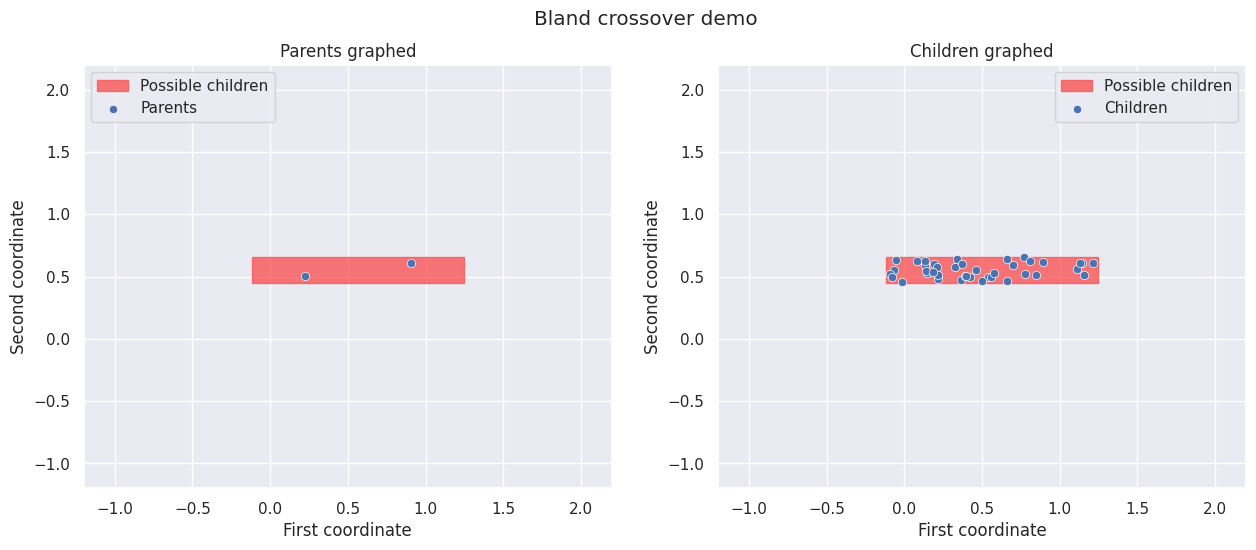

In [25]:
crossover = Crossover('demo')
crossover.params = {}
crossover.params['alpha'] = 0.5

system_size = 2

parent1 = np.empty(system_size)
parent2 = np.empty(system_size)

for i in range(sistem_size):
    parent1[i] = random.random()
    parent2[i] = random.random()

number_of_tries = 20 #10 times we will do crossover between this parents, that means we will produce 40 children

children = np.array([[-10, -10]])#[-10, -10] is placeholder to give array a shape of (1, 2)
for _ in range(number_of_tries):
    offspring = crossover._bland_crossover(mating_pool=np.array([parent1, parent2]), fitness=None)#This approach does not use fitness so it is ok to pass None
    children = np.append(children, offspring, axis=0)

#Creating variables to draw rectangle
#Rectangle will represent where will be possible children
center = (parent1 + parent2) / 2
width = abs(parent1[0] - center[0]) * 2
height = abs(parent1[1] - center[1]) * 2

width += crossover.params['alpha'] * width * 2
height += crossover.params['alpha'] * height * 2

down_left_dot = [center[0] - width/2, center[1] - height/2]

#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')
axs1[0].add_patch(
    patches.Rectangle((down_left_dot[0], down_left_dot[1]), width, height, color=(249/255.0, 86/255.0, 86/255.0, 0.8), label='Possible children'))
sns.scatterplot(x=[individual[0] for individual in [parent1, parent2]], y=[individual[1] for individual in [parent1, parent2]], ax=axs1[0], label='Parents')

axs1[1].add_patch(
    patches.Rectangle((down_left_dot[0], down_left_dot[1]), width, height, color=(249/255.0, 86/255.0, 86/255.0, 0.8), label='Possible children'))
sns.scatterplot(x=[individual[0] for individual in children], y=[individual[1] for individual in children], ax=axs1[1], label='Children')


axs1[0].legend(loc=2)

axs1[0].set_xlim([-1.2, 2.2])
axs1[0].set_ylim([-1.2, 2.2])

axs1[1].set_xlim([-1.2, 2.2])
axs1[1].set_ylim([-1.2, 2.2])

fig1.suptitle('Bland crossover demo')
axs1[0].set_title('Parents graphed')
axs1[1].set_title('Children graphed')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')
pass

---
### <a id="sbx">SBX</a>

Simulated binary crossover tries to implement all the good properties of one point crossover from binary GA.

Formula:<br>
$u$ is random number and, $u \in [0, 1)$<br>
$\Large\beta = \begin{cases} (2u)^\frac{1}{\eta_c} & ,u \le 0.5 \\ (\frac{1}{2(1-u)})^\frac{1}{\eta_c} & ,\text{otherwise} \end{cases}$<br>
Where $\eta_c$ is distribution index, lower value will create more diverse individuals while with the higher values individuals will be 'similar' to the parents.<br>

Child Creation

In the original paper authors are describing how are they dealing with 'multi-variable' problems (multidimensional individuals as we called them here), and inspiration for solution they got from uniform crossover used in binary GA. Uniform crossover tosses a coin whether to swap bits or not, for every bits in the parent. So for multidimensional individuals they toss a coin for every dimension whether to crossover them or not.

Parameters:<br>
<b>distribution_index</b> is float that represents distribution index of offspring

In [26]:
class Crossover(Crossover):
    def _sbx(self, mating_pool: np.array, fitness: Fitness):
        system_size = len(mating_pool[0])
        offspring = np.empty(shape=mating_pool.shape)
        distribution_index = self.params['distribution_index']
        probability_of_crossover = self._probability_of_crossover if system_size > 1 else 1
        
        for i in range(0, len(mating_pool), 2):
            parent1 = mating_pool[i]
            parent2 = mating_pool[i+1]
            child1 = np.empty(system_size)
            child2 = np.empty(system_size)
            for j in range(system_size):
                u = random.random()
                if(u < 0.5):
                    u = 2 * u
                else:
                    u = 1.0/(2.0 * (1-u))
                beta = u**(1.0/distribution_index)
                if(random.random() < probability_of_crossover):
                    child1[j] = 0.5*((1+beta)*parent1[j] + (1-beta)*parent2[j])
                    child2[j] = 0.5*((1-beta)*parent1[j] + (1+beta)*parent2[j])
                else:
                    child1[j] = parent1[j]
                    child2[j] = parent2[j]

            offspring[i:i+2] = [child1, child2]

        return offspring

#### Demo

Text(0, 0.5, 'Second coordinate')

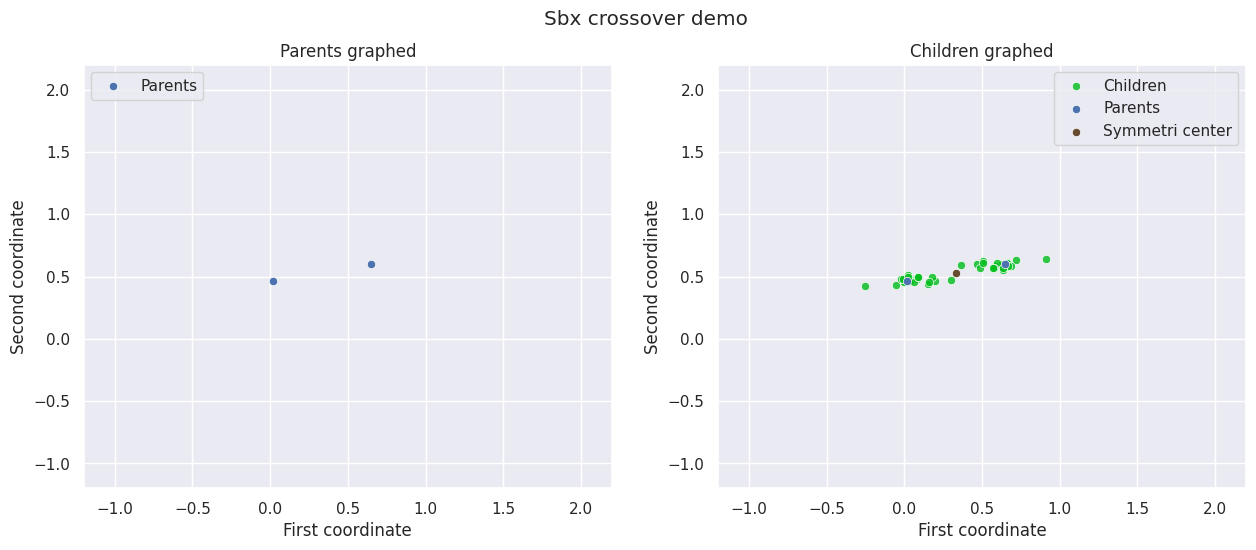

In [27]:
crossover = Crossover('demo')
crossover.params = {}
crossover.params['distribution_index'] = 2.2
crossover._probability_of_crossover = 1

system_size = 2

parent1 = np.empty(system_size)
parent2 = np.empty(system_size)

for i in range(sistem_size):
    parent1[i] = random.random()
    parent2[i] = random.random()

number_of_tries = 20 #20 times we will do crossover between this parents, that means we will produce 40 children

children = np.array([[-10, -10]])#[-10, -10] is placeholder to give array a shape of (1, 2)
for _ in range(number_of_tries):
    offspring = crossover._sbx(mating_pool=np.array([parent1, parent2]), fitness=None)#This approach does not use fitness so it is ok to pass None
    children = np.append(children, offspring, axis=0)

#Finding the center of the symmetry
center = (parent1 + parent2) / 2



#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')

sns.scatterplot(x=[individual[0] for individual in [parent1, parent2]], y=[individual[1] for individual in [parent1, parent2]], ax=axs1[0], label='Parents')

sns.scatterplot(x=[individual[0] for individual in children], y=[individual[1] for individual in children], ax=axs1[1], label='Children', color=(0/255, 190/255, 28/255, 0.8))
sns.scatterplot(x=[individual[0] for individual in [parent1, parent2]], y=[individual[1] for individual in [parent1, parent2]], ax=axs1[1], label='Parents')
sns.scatterplot(x=[center[0]], y=[center[1]], label='Symmetri center', color=(72/255, 37/255, 0/255, 0.8))

axs1[0].legend(loc=2)

axs1[0].set_xlim([-1.2, 2.2])
axs1[0].set_ylim([-1.2, 2.2])

axs1[1].set_xlim([-1.2, 2.2])
axs1[1].set_ylim([-1.2, 2.2])

fig1.suptitle('Sbx crossover demo')
axs1[0].set_title('Parents graphed')
axs1[1].set_title('Children graphed')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')

SBX produces also symmetrical children, but the difference is that children are not on a line and rather they are spread near their parents.

Maybe I should add one more example of how the parameter changes the children distribution.

## Crossover class

In [28]:
class Crossover(Crossover):
    VALID_CROSSOVER_STRATS = ['symmetric',
                             'linear',
                             'bland',
                             'sbx',]
    DEFAULT_ALPHA = 0.5
    DEFAULT_DISTRIBUTION_INDEX = 1.5

    def get_possible_strats(self):
        return str(self.VALID_CROSSOVER_STRATS)
        
    def _check_strat(self, crossover_strat: str):
        if not crossover_strat in self.VALID_CROSSOVER_STRATS:
            raise ValueError('Crossover strategy name is not recognised, you can use crossover_strat=' + self.get_possible_strats())

    def _set_crossover(self, crossover_strat: str, **kwargs):
        if(crossover_strat == 'symmetric'):
            self._crossover = self._symmetrical_crossover
            
        elif(crossover_strat == 'linear'):
            self._crossover = self._linear_crossover
        
        elif(crossover_strat == 'bland'):
            self._crossover = self._bland_crossover
            check_parameter(self, 'alpha', 'bland', 'crossover', self.DEFAULT_ALPHA, (int, float), kwargs)
            self.params['alpha'] = float(self.params['alpha'])
        
        elif(crossover_strat == 'sbx'):
            self._crossover = self._sbx
            check_parameter(self, 'distribution_index', 'sbx', 'crossover', self.DEFAULT_DISTRIBUTION_INDEX, (int, float), kwargs)
            self.params['distribution_index'] = float(self.params['distribution_index'])
            
        else:
            raise AssertionError('Crossover strategy name exist in the valid crossover strategies but was not found')
    
    def __init__(self, crossover_strat: str, *, alpha=None, distribution_index=None):
        self._crossover_strat = crossover_strat
        self._check_strat(crossover_strat)
        self._set_crossover(crossover_strat, alpha=alpha, distribution_index=distribution_index)

    def generate_offspring(self, mating_pool: np.array, fitness: Fitness) -> np.array:
        return self._crossover(mating_pool, fitness)

    def get_info(self):
        return f'Crossover strategy - {self._crossover_strat} with next parameters:'+ ('\n\t'.join("{0} = {1}".format(key, value)  for key,value in self.params.items()) if self.params.items() else f'\n\tMethod have no parameters') 

## <a id='replacement_strategy'>Replacement strategy</a>

We will be creating 3 types of replacement strategies:
- Best n (offspring and original population are combined and top n survives)
- Elitism (best % of original population is saved and other is filled with offspring)
- Random

In [29]:
class Replacement():
    pass

### Best n

In [30]:
class Replacement(Replacement):
    def _best_n(self, offspring: np.array, offspring_fitness: np.array, population: np.array, population_fitness: np.array) -> np.array:
        everyone = np.concatenate((offspring, population))
        everyone_fitness = np.concatenate((offspring_fitness, population_fitness))
        sorted_all = np.flip(everyone[np.argsort(everyone_fitness)], axis=0)
        return sorted_all[:len(population)]

In [31]:
class Replacement(Replacement):
    def _elitism(self, offspring: np.array, offspring_fitness: np.array, population: np.array, population_fitness: np.array) -> np.array:
        elitism_width = self.params['elitism_width']
        sorted_offspring = np.flip(offspring[np.argsort(offspring_fitness)], axis=0)
        sorted_population = np.flip(population[np.argsort(population_fitness)], axis=0)
        number_survived_parents = round(len(population) * elitism_width)
        number_offspring_survived = len(population) - number_survived_parents
        return np.concatenate((sorted_population[:number_survived_parents], sorted_offspring[:number_offspring_survived]))

In [32]:
class Replacement(Replacement):
    def _random(self, offspring: np.array, offspring_fitness: np.array, population: np.array, population_fitness: np.array) -> np.array:
        everyone = np.concatenate((offspring, population))
        return np.array(random.choices(everyone, k=len(population)))

## Replacement class

In [33]:
class Replacement(Replacement):
    VALID_REPLACEMENT_STRATS = ['best',
                               'elitism',
                               'random']
    DEFAULT_ELITISM_WIDTH = 0.05

    def get_possible_strats(self):
        return str(self.VALID_REPLACEMENT_STRATS)
    
    def _check_params(self, replacement_strat: str):
        if not replacement_strat in self.VALID_REPLACEMENT_STRATS:
            raise ValueError('Replacement strategy name is not recognised, you can use replacement_strat=' + self.get_possible_strats())

    def _set_replacement(self, replacement_strat: str, **kwargs):
        if(replacement_strat == 'best'):
            self._replacement = self._best_n
            
        elif(replacement_strat == 'elitism'):
            self._replacement = self._elitism
            check_parameter(self, 'elitism_width', 'elitism', 'replacement', self.DEFAULT_ELITISM_WIDTH, (float), kwargs)
            if(self.params['elitism_width'] >= 1.0):
                self.params['elitism_width'] = 1.0
                warnings.warn('Setting elitism width to be more than 1 (100%) means than all of the original population will surivive all the time.')
        
        elif(replacement_strat == 'random'):
            self._replacement = self._random
        
        else:
            raise AssertionError('Replacement strategy name exist in the valid replacement strategies but was not found')
    
    def __init__(self, replacement_strat: str, *, elitism_width=None):
        self._replacement_strat = replacement_strat
        self._check_params(replacement_strat)
        self._set_replacement(replacement_strat, elitism_width=elitism_width)

    def replace(self, offspring: np.array, offspring_fitness: np.array, population: np.array, population_fitness: np.array) -> np.array:
        return self._replacement(offspring, offspring_fitness, population, population_fitness)

## Mutation

In [34]:
class Mutation():
    #This is not constructor intended to be used if you are not debugging or expanding library
    def __init__(self, mode: str):
        valid = ['debug', 'demo']
        if not mode in valid:
            raise ValueError('Unknown mode')

### Random mutation

Random mutation 'moves' individual in the certain range.<br>
$x_{new} = x + r * n$ where<br>
$r$ is the parameter and $r$ represents mutation strength. Individuals will change in range $[x-r, x+r]$.<br>
$n$ is random number and $n \in [-1, 1]$

In [35]:
class Mutation(Mutation):
    def _random_mutation(self, population: np.array, mutation_probability: float, dimension_probability: float):
        mutation_strength = self.params['mutation_strength']
        dimension_probability = dimension_probability if len(population[0]) > 1 else 1 #If there is more than 1 dimension we look at dimension_probability
        for i in range(len(population)):
            if(random.random() > mutation_probability): continue
            individual = population[i]
            for j in range(len(individual)):
                if(random.random() > dimension_probability): continue
                population[i][j] += mutation_strength * (2 * (random.random() - 0.5))
            

#### Demo

Text(0, 0.5, 'Second coordinate')

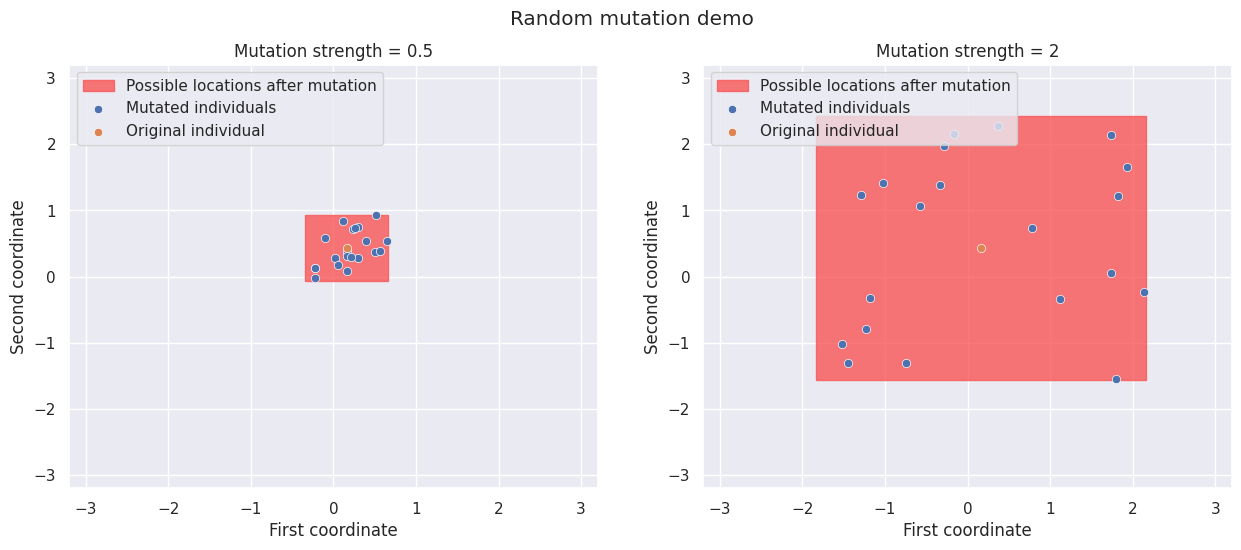

In [36]:
mutation = Mutation('demo')
mutation.params = {}
mutation_strength1 = 0.5
mutation_strength2 = 2

sistem_size = 2

original_individual = np.empty(sistem_size)

for i in range(sistem_size):
    original_individual[i] = random.random()

number_of_tries = 20

mutations1 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation.params['mutation_strength'] = mutation_strength1
mutation._random_mutation(mutations1, 1, 1)

mutations2 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation.params['mutation_strength'] = mutation_strength2
mutation._random_mutation(mutations2, 1, 1)

#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')


center = original_individual
#First plot
axs1[0].add_patch(
    patches.Rectangle((center[0]-mutation_strength1, center[1]-mutation_strength1), mutation_strength1*2, mutation_strength1*2, color=(249/255.0, 86/255.0, 86/255.0, 0.8), label='Possible locations after mutation'))
sns.scatterplot(x=[individual[0] for individual in mutations1], y=[individual[1] for individual in mutations1], ax=axs1[0], label='Mutated individuals')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs1[0], label='Original individual')


#Second plot
axs1[1].add_patch(
    patches.Rectangle((center[0]-mutation_strength2, center[1]-mutation_strength2), mutation_strength2*2, mutation_strength2*2, color=(249/255.0, 86/255.0, 86/255.0, 0.8), label='Possible locations after mutation'))
sns.scatterplot(x=[individual[0] for individual in mutations2], y=[individual[1] for individual in mutations2], ax=axs1[1], label='Mutated individuals')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs1[1], label='Original individual')

axs1[0].legend(loc=2)
axs1[1].legend(loc=2)


axs1[0].set_xlim([-3.2, 3.2])
axs1[0].set_ylim([-3.2, 3.2])

axs1[1].set_xlim([-3.2, 3.2])
axs1[1].set_ylim([-3.2, 3.2])

fig1.suptitle('Random mutation demo')
axs1[0].set_title('Mutation strength = 0.5')
axs1[1].set_title('Mutation strength = 2')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')

### Nonuniform mutation

Nonuniform mutation is described with following equation:<br>
$\Large x_{new} = x + \tau(x_{max} - x_{min})(1-r^{(1-t/t_{max})^b})$<br>
$\tau \in \{-1, 1\}$<br>
$r \in [0, 1]$<br>
$t_{max}$ is the maximum number of generation<br>
$t$ is the current generation<br>
$x_{max}$ and $x_{min}$ are maximal and minimal bound of values $x$ can take.

In [37]:
class Mutation(Mutation):
    #Need to change the names of variables
    def _nonuniform_mutation(self, population: np.array, mutation_probability: float, dimension_probability: float):
        maximum_generations = self._maximum_generations
        current_generation = self._current_generation
        mutation_strength = self.params['mutation_strength']
        b = self.params['b']
        dimension_probability = dimension_probability if len(population[0]) > 1 else 1
        
        for i in range(len(population)):
            if(random.random() > mutation_probability): continue
            individual = population[i]
            for j in range(len(individual)):
                if(random.random() > dimension_probability): continue
                tau = -1 if random.randrange(2) == 0 else 1
                population[i,j] += tau*(mutation_strength)*(1 - random.random()**(1-current_generation/maximum_generations)**b)

#### Demo

In the example bellow we are going to look at the change of the current generation as well as the change of the parameter b of the nonuniform generation.

Text(0, 0.5, 'Second coordinate')

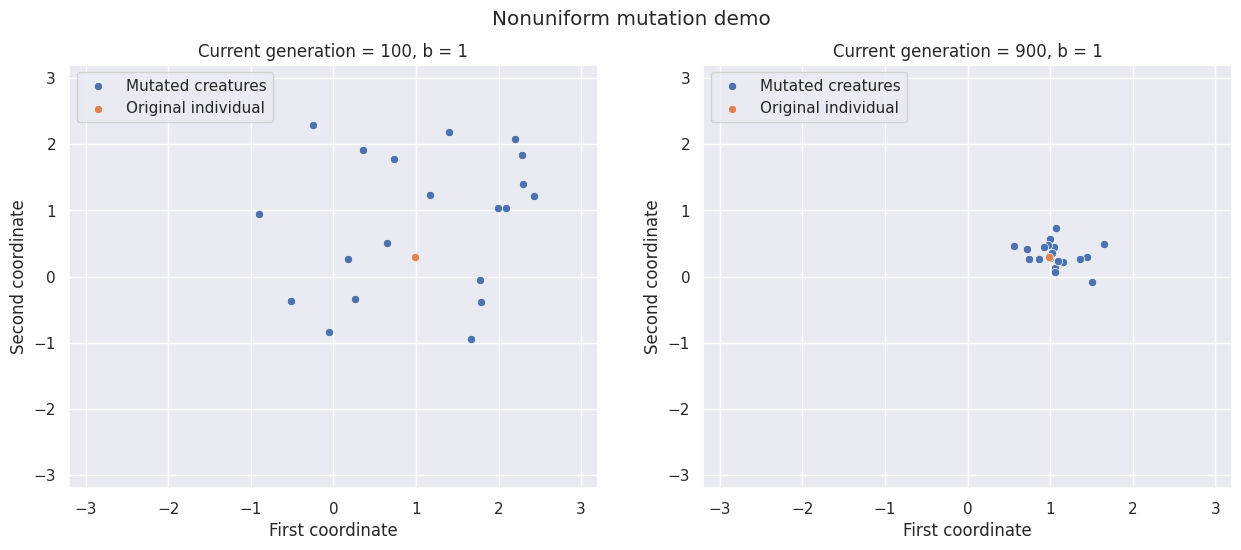

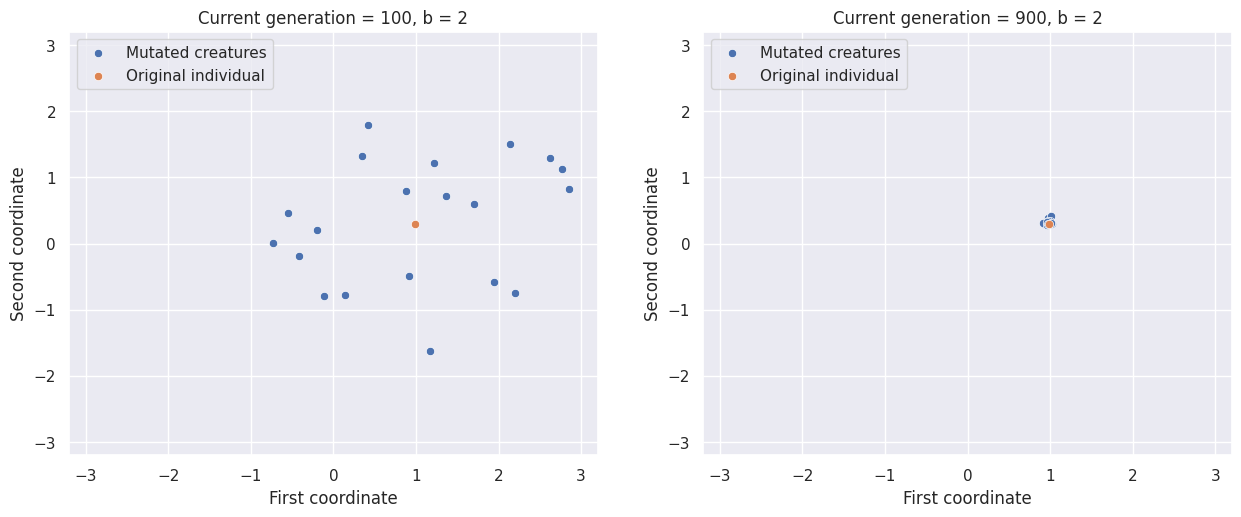

In [38]:
#If you want to see demo with different parameters, change them here
b1 = 1
b2 = 2
current_generation1 = 100
current_generation2 = 900
################



mutation = Mutation('demo')
mutation.params = {}
mutation.params['mutation_strength'] = 2
mutation._maximum_generations = 1000

sistem_size = 2

original_individual = np.empty(sistem_size)

for i in range(sistem_size):
    original_individual[i] = random.random()

number_of_tries = 20

mutations1 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation._current_generation = current_generation1
mutation.params['b'] = b1
mutation._nonuniform_mutation(mutations1, 1, 1)

mutations2 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation._current_generation = current_generation2
mutation.params['b'] = b1
mutation._nonuniform_mutation(mutations2, 1, 1)

mutations3 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation._current_generation = current_generation1
mutation.params['b'] = b2
mutation._nonuniform_mutation(mutations3, 1, 1)

mutations4 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation._current_generation = current_generation2
mutation.params['b'] = b2
mutation._nonuniform_mutation(mutations4, 1, 1)

#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')
fig2, axs2 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')

#First plot
sns.scatterplot(x=[individual[0] for individual in mutations1], y=[individual[1] for individual in mutations1], ax=axs1[0], label='Mutated creatures')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs1[0], label='Original individual')

#Second plot
sns.scatterplot(x=[individual[0] for individual in mutations2], y=[individual[1] for individual in mutations2], ax=axs1[1], label='Mutated creatures')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs1[1], label='Original individual')

#Third plot
sns.scatterplot(x=[individual[0] for individual in mutations3], y=[individual[1] for individual in mutations3], ax=axs2[0], label='Mutated creatures')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs2[0], label='Original individual')

#Fourth plot
sns.scatterplot(x=[individual[0] for individual in mutations4], y=[individual[1] for individual in mutations4], ax=axs2[1], label='Mutated creatures')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs2[1], label='Original individual')


axs1[0].legend(loc=2)
axs1[1].legend(loc=2)
axs2[0].legend(loc=2)
axs2[1].legend(loc=2)

axs1[0].set_xlim([-3.2, 3.2])
axs1[0].set_ylim([-3.2, 3.2])

axs1[1].set_xlim([-3.2, 3.2])
axs1[1].set_ylim([-3.2, 3.2])

axs2[0].set_xlim([-3.2, 3.2])
axs2[0].set_ylim([-3.2, 3.2])

axs2[1].set_xlim([-3.2, 3.2])
axs2[1].set_ylim([-3.2, 3.2])


fig1.suptitle('Nonuniform mutation demo')
axs1[0].set_title(f'Current generation = {current_generation1}, b = {b1}')
axs1[1].set_title(f'Current generation = {current_generation2}, b = {b1}')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')

fig2.suptitle('')
axs2[0].set_title(f'Current generation = {current_generation1}, b = {b2}')
axs2[1].set_title(f'Current generation = {current_generation2}, b = {b2}')
axs2[0].set_xlabel('First coordinate')
axs2[0].set_ylabel('Second coordinate')
axs2[1].set_xlabel('First coordinate')
axs2[1].set_ylabel('Second coordinate')

### Normally distributed mutation

Normally distributed mutation mutates individuals with Gaussian distribution.<br>
$x_{new} = x + \text{N}(0, \sigma)$

In [39]:
class Mutation(Mutation):
    def _normally_distributed_mutaiton(self, population: np.array, mutation_probability: float, dimension_probability: float):
        standard_deviation = self.params['standard_deviation']
        for i in range(len(population)):
            if(random.random() > mutation_probability): continue
            individual = population[i]
            for j in range(len(individual)):
                if(random.random() > dimension_probability): continue
                population[i,j] += random.gauss(mu=0, sigma=standard_deviation)

#### Demo

Text(0, 0.5, 'Second coordinate')

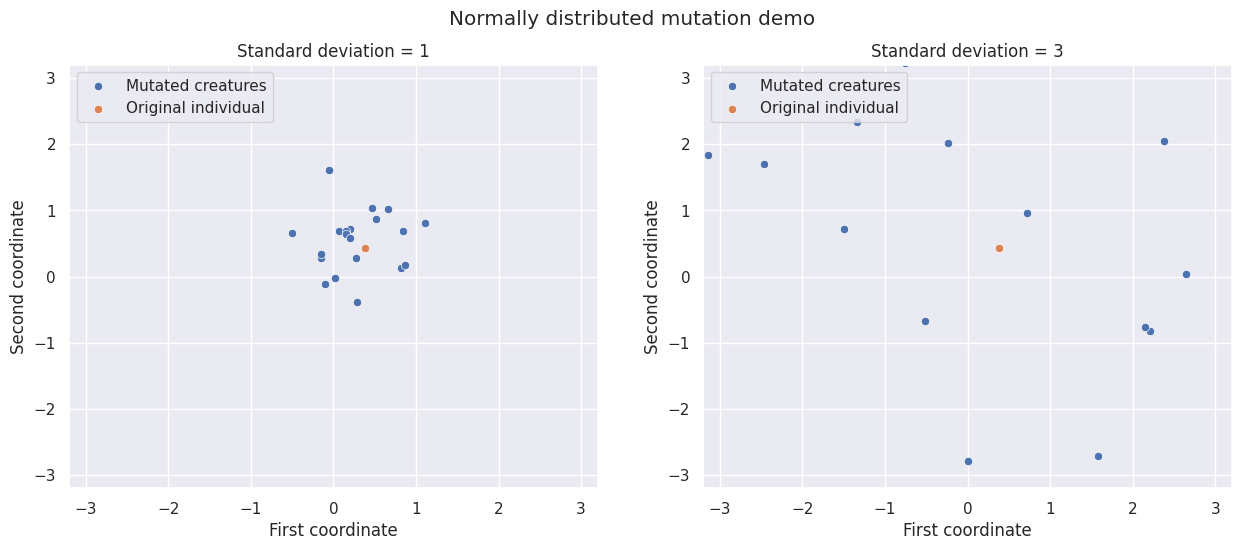

In [40]:
mutation = Mutation('demo')
mutation.params = {}

sistem_size = 2

original_individual = np.empty(sistem_size)

for i in range(sistem_size):
    original_individual[i] = random.random()

number_of_tries = 20

mutations1 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation.params['standard_deviation'] = 0.5
mutation._normally_distributed_mutaiton(mutations1, 1, 1)

mutations2 = np.full_like(np.empty(shape=(number_of_tries, sistem_size)), original_individual)#[-10, -10] is placeholder to give array a shape of (1, 2)
mutation.params['standard_deviation'] = 2.5
mutation._normally_distributed_mutaiton(mutations2, 1, 1)

#Plotting
fig1, axs1 = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(15, 5.5))
sns.set_theme(style='darkgrid', context='notebook')

#First plot
sns.scatterplot(x=[individual[0] for individual in mutations1], y=[individual[1] for individual in mutations1], ax=axs1[0], label='Mutated creatures')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs1[0], label='Original individual')

#Second plot
sns.scatterplot(x=[individual[0] for individual in mutations2], y=[individual[1] for individual in mutations2], ax=axs1[1], label='Mutated creatures')
sns.scatterplot(x=[original_individual[0]], y=[original_individual[1]], ax=axs1[1], label='Original individual')

axs1[0].legend(loc=2)
axs1[1].legend(loc=2)


axs1[0].set_xlim([-3.2, 3.2])
axs1[0].set_ylim([-3.2, 3.2])

axs1[1].set_xlim([-3.2, 3.2])
axs1[1].set_ylim([-3.2, 3.2])

fig1.suptitle('Normally distributed mutation demo')
axs1[0].set_title('Standard deviation = 1')
axs1[1].set_title('Standard deviation = 3')
axs1[0].set_xlabel('First coordinate')
axs1[0].set_ylabel('Second coordinate')
axs1[1].set_xlabel('First coordinate')
axs1[1].set_ylabel('Second coordinate')

## Mutation class

In [41]:
class Mutation(Mutation):
    VALID_MUTATION_STRATS = ['random',
                             'nonuniform',
                             'normal',]
    DEFAULT_B = 1.0
    DEFAULT_MUTATION_STRENGTH = 0.2
    DEFAULT_STANDARD_DEVIATION = 1.0

    def get_possible_strats(self):
        return str(self.VALID_MUTATION_STRATS)
    
    def _check_params(self, mutation_strat: str):
        if not mutation_strat in self.VALID_MUTATION_STRATS:
            raise ValueError('Mutation strategy name is not recognised, you can use mutation_strat=' + self.get_possible_strats())

    def _set_mutation(self, mutation_strat: str, **kwargs):
        if(mutation_strat == 'random'):
            self._mutation = self._random_mutation
            check_parameter(self, 'mutation_strength', 'random', 'mutation', self.DEFAULT_MUTATION_STRENGTH, (int, float), kwargs)
            self.params['mutation_strength'] = float(self.params['mutation_strength'])
        
        elif(mutation_strat == 'nonuniform'):
            self._mutation = self._nonuniform_mutation
            check_parameter(self, 'b', 'nonuniform', 'mutation', self.DEFAULT_B, (int, float), kwargs)
            self.params['b'] = float(self.params['b'])
            check_parameter(self, 'mutation_strength', 'nonuniform', 'mutation', self.DEFAULT_MUTATION_STRENGTH, (int, float), kwargs)
            self.params['mutation_strength'] = float(self.params['mutation_strength'])
            
        elif(mutation_strat == 'normal'):
            self._mutation = self._normally_distributed_mutaiton
            check_parameter(self, 'standard_deviation', 'normal', 'mutation', self.DEFAULT_STANDARD_DEVIATION, (int, float), kwargs)
            self.params['standard_deviation'] = float(self.params['standard_deviation'])
        
        else:
            raise AssertionError('Mutation strategy name exist in the valid mutation strategies but was not found')
    
    def __init__(self, mutation_strat: str, mutation_probability: float, dimension_probability: float, *, b=None, standard_deviation=None, mutation_strength=None):
        self._check_params(mutation_strat)
        self._set_mutation(mutation_strat, b=b, standard_deviation=standard_deviation, mutation_strength=mutation_strength)
        self._mutation_probability = mutation_probability
        self._dimension_probability = dimension_probability

In [42]:
class Mutation(Mutation):
    def initialize(self, maximum_generations: int):
        self._maximum_generations = maximum_generations
        self._current_generation = 1

    def update(self):
        self._current_generation += 1

    def mutate_population(self, population: np.array) -> None:
        self._mutation(population, self._mutation_probability, self._dimension_probability)
        

## Main class

In [43]:
class GA():
    def __init__(self, fitness: Fitness, selection: Selection, crossover: Crossover, replacement: Replacement, mutation: Mutation):
        self._population = None
        self._fitness = fitness
        self._selection = selection
        self._crossover = crossover
        self._replacement = replacement
        self._mutation = mutation
        
    def initialize_population(self, number_of_individuals: int, interval_min: int, interval_max: int):
        system_size = fitness.system_size
        self._population = np.empty((number_of_individuals, system_size))
        for i in range(number_of_individuals):
            individual = np.empty((system_size, ))
            for j in range(system_size):
                individual[j] = random.uniform(interval_min, interval_max)
            self._population[i] = np.copy(individual)
        self._population = self._fitness.rank(self._population)

    def run(self, number_of_individuals: int, interval_min: int, interval_max: int, rounds, *, save=False, file_name='ga', verbose=0, early_stopping_rounds=-1, run_times=1, fitness_function_name='Not given'):
        
        #Variables for storing all runs best individuals and other info
        best_individuals = []
        best_fitness_values = []
        total_rounds = []
        times = []
        
        for k in range(run_times):
            start_time = time.time()

            self.initialize_population(number_of_individuals, interval_min, interval_max)
            max_ind = self._population[0]
            max_fit = fitness.funciton(max_ind)
            
            self._mutation.initialize(rounds)
            round_without_new_max = 0
            for i in range(rounds):
                round_without_new_max += 1
                
                mating_pool = self._selection.select_mating_pool(self._population, self._fitness, number_of_individuals)
                offspring = self._crossover.generate_offspring(mating_pool, self._fitness)
                self._mutation.mutate_population(offspring)
                self._population = self._replacement.replace(offspring, self._fitness.calculate_fitness(offspring),
                                                             self._population, self._fitness.calculate_fitness(self._population))
                self._mutation.update()
                self._population = self._fitness.rank(self._population)
                round_max_fit = self._fitness.funciton(self._population[0])

                #Printing progress
                if verbose and verbose > 0:
                    if i % verbose == 0:
                        print(f'Printing info for run {k} and round {i}:\n'
                             +f'\t Current max fit:{max_fit}\n'
                             +f'\t Current max ind:{max_ind}\n'
                             +f'\t Round max fit:{round_max_fit}\n'
                             +f'\t Round max ind:{self._population[0]}\n')

                #Checking for new best
                if(round_max_fit > max_fit):
                    max_fit = round_max_fit
                    max_ind = self._population[0]
                    round_without_new_max = 0

                #Checking for early stropping
                if(round_without_new_max >= early_stopping_rounds and early_stopping_rounds > 0):
                    break
            end_time = time.time()
            
            print(f'Time to execute {k} run is: {end_time - start_time}')
            if(round_without_new_max >= early_stopping_rounds and early_stopping_rounds > 0):
                print('Stopped due to reaching early_stopping_rounds')
            print(f'Found solution in {i} round.')
            print(f'Best individual fitness: {max_fit}')
            print(f'Individual value is: {max_ind}')

            #Storing run info
            best_individuals.append(max_ind)
            best_fitness_values.append(max_fit)
            total_rounds.append(i)
            times.append(end_time-start_time)
        #End of all runs
    
    def save_to_file(self, file_name: str):
        if not file_name.endswith('.txt'):
            file_name.removesuffix('.txt')
        try:
            f = open(file_name + '.txt', 'x')
        except FileExistsError:
            i = 0
            while True:
                try:
                    f = open(file_name+'_'+str(i)+'.txt', 'x')
                    break
                except FileExistsError:
                    i += 1
        #Have f file
        #TODO write
        f.write('')
        f.write('Hello')

    def read_from_file(self):
        #TODO
        pass